# Helmet Violation Detection from Indian CCTV Video

**Problem statement:**
Detect and flag two-wheeler helmet violations (helmetless riding) from traffic camera frames in Indian cities in real-time.

**Description:**
Create a computer vision system using YOLOv8 and object tracking to detect two-wheeler riders and classify helmet usage. Optionally perform license plate OCR for enforcement.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile
import os

# Define the path to the zip file and the extraction directory within Google Drive
zip_file_path = '/content/drive/My Drive/capstone_helmet_detection/archive2.zip'
extraction_path = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"Successfully extracted {zip_file_path} to {extraction_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: The file at {zip_file_path} is not a valid zip file.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted /content/drive/My Drive/capstone_helmet_detection/archive2.zip to /content/drive/My Drive/capstone_helmet_detection/unzipped_archive


In [24]:
import os

image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images'
annotations_dir = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels'
files_in_image_directory = os.listdir(image_directory)

image_count = 0
for filename in files_in_image_directory:
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_count += 1

print(f"Total files in {image_directory}: {len(files_in_image_directory)}")
print(f"Image files in {image_directory}: {image_count}")

Total files in /content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images: 800
Image files in /content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images: 800


** Size analysis


       Width  Height
count  800.0   800.0
mean   640.0   640.0
std      0.0     0.0
min    640.0   640.0
25%    640.0   640.0
50%    640.0   640.0
75%    640.0   640.0
max    640.0   640.0


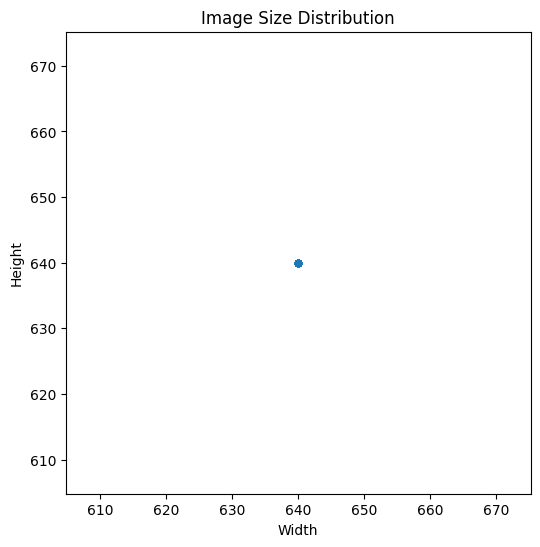

In [25]:
from PIL import Image
import pandas as pd
import os # Import os module

image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images' # Update image_directory
all_images = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sizes = []
for img_path in all_images[:800]:
    with Image.open(img_path) as img:
        sizes.append(img.size)

df_sizes = pd.DataFrame(sizes, columns=["Width", "Height"])
print(df_sizes.describe())

# Need to import matplotlib.pyplot
import matplotlib.pyplot as plt

df_sizes.plot(kind="scatter", x="Width", y="Height", alpha=0.5, figsize=(6,6))
plt.title("Image Size Distribution")
plt.show()

In [26]:
import os

annotations_dir = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels' # Update annotations_dir
class_counts = {}
for filename in os.listdir(annotations_dir):
    if filename.lower().endswith('.txt'):
        try:
            with open(os.path.join(annotations_dir, filename), 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    if class_id in class_counts:
                        class_counts[class_id] += 1
                    else:
                        class_counts[class_id] = 1
        except Exception as e:
            print(f"Could not read annotation file {filename}: {e}")

print("Class distribution:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count}")

Class distribution:
Class 2: 1787
Class 4: 1750
Class 0: 1327
Class 3: 293
Class 1: 791


In [49]:
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display random images with bounding boxes from a given list of filenames
def display_random_images_with_bboxes(image_filenames, image_directory, annotation_directory, num_samples=5):
    """
    Displays random images with bounding boxes from a list of filenames.

    Args:
        image_filenames (list): A list of image filenames to choose from.
        image_directory (str): The directory where the images are located.
        annotation_directory (str): The directory where the annotation files are located.
        num_samples (int): The number of random images to display.
    """
    if not image_filenames:
        print("No image files provided in the list.")
        return

    # Select random image files from the provided list
    num_samples = min(num_samples, len(image_filenames)) # Ensure we don't ask for more samples than available
    random_image_filenames = random.sample(image_filenames, num_samples)

    for image_filename in random_image_filenames:
        image_path = os.path.join(image_directory, image_filename)
        annotation_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt') # Assuming .txt annotations
        annotation_path = os.path.join(annotation_directory, annotation_filename)

        # Load the image using PIL and convert to OpenCV format
        try:
            pil_image = Image.open(image_path)
            # Convert PIL image to NumPy array (BGR format for OpenCV)
            image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
            h, w, _ = image.shape
        except Exception as e:
            print(f"Could not load or process image {image_path}: {e}")
            image = None # Set image to None if loading fails

        # Read the annotation file and draw bounding boxes
        if image is not None and os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                for line in f:
                    try:
                        # YOLO format: class_id center_x center_y width height (normalized)
                        class_id, center_x, center_y, bbox_width, bbox_height = map(float, line.split())

                        # Convert normalized coordinates to pixel coordinates
                        x_center = int(center_x * w)
                        y_center = int(center_y * h)

                        box_w = int(bbox_width * w)
                        box_h = int(bbox_height * h)

                        # Calculate top-left corner coordinates
                        x_min = int(x_center - box_w / 2)
                        y_min = int(y_center - box_h / 2)
                        x_max = int(x_center + box_w / 2)
                        y_max = int(y_center + box_h / 2)

                        # Draw bounding box (Green color, thickness 2)
                        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                        # Put class label (using class_id for now)
                        label = f"Class: {int(class_id)}"
                        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    except Exception as e:
                        print(f"Could not process annotation line in {annotation_filename}: {line.strip()} - {e}")


            # Display the image (using matplotlib)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(8, 8)) # Adjust figure size for better viewing
            plt.imshow(image_rgb)
            plt.title(f"Image: {image_filename}")
            plt.axis('off')
            plt.show()


        elif image is None:
            print(f"Skipping {image_filename} due to loading error.")
        else:
            print(f"Annotation file not found for {image_filename}")

# The original code in this cell has been moved into the function above.
# This cell now only defines the function. To display images, call this function
# from another cell, providing the list of image filenames you want to sample from.

In [35]:
import os

image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images'

try:
    files = os.listdir(image_directory)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print("Available image files:")
    for i, filename in enumerate(image_files[:20]): # Print first 20 files as an example
        print(filename)
    if len(image_files) > 20:
        print(f"... and {len(image_files) - 20} more.")
except FileNotFoundError:
    print(f"Error: The directory {image_directory} was not found.")
except Exception as e:
    print(f"An error occurred while listing files: {e}")

Available image files:
013_93_jpeg.rf.24b090d0026ca8d62a13f69f03514f4a.jpg
Screenshot-2023-08-02-at-12-14-36-PM_png.rf.35c40e8de9d9cac39e3ba913fd7d7a95.jpg
033_257_png_jpg.rf.fdf8035e004aec363ffd433b652a391b.jpg
Screenshot-2023-07-28-230104_png_jpg.rf.c19200eb3cff387bea167e3d430aa584.jpg
033_009_jpeg_jpg.rf.a08a698646122456250ae6e34cf7c7b5.jpg
033_302_png_jpg.rf.8d9d19272b1967e16dc180453d9791c3.jpg
036_95_jpg.rf.311264804780d4a803982bc347200222.jpg
036_183_jpg.rf.b0abb862387dd1aa0e4ab29c3360857e.jpg
098-Rhythm16_jpg.rf.da25b72a876f42de2ccc905162069434.jpg
Screenshot-2023-07-28-230258_png_jpg.rf.dfdd2b3de543f41ae780631368790158.jpg
013_123_jpeg.rf.fcb9de10a904093cca957bbcb4582b80.jpg
013_114_jpeg.rf.10742678abfd222d7b9278dc4aa93d0f.jpg
036_108_jpg.rf.b5d5569f44ac8934e228ee7d7d640172.jpg
Screenshot-2023-07-28-225755_png_jpg.rf.b69a82fa7c0a9c231264fb3e51c5a4c9.jpg
051_21_jpg.rf.8980d28cad6623f586813a9ab493ff4a.jpg
036_147_jpg.rf.4cf2b9cc3bcd7303f7b6729af5d2c3b5.jpg
033_300_png_jpg.rf.a8dd

--- Basic Image Quality Checks (Black/Low Variance/Color Stats) ---
Number of black images: 0
Number of low variance images: 0
Average color per channel (BGR): [112.97445556 117.01440137 118.84707956]
Standard deviation of color per channel (BGR): [25.03654524 25.34162269 25.71004446]


--- Sharpness/Blur Detection (Laplacian Variance) ---
Top 10 potentially blurriest images (path, Laplacian variance):
/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images/013_144_jpeg.rf.bb31c4e313167342eb2cd34d690191a4.jpg: 33.93
/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images/Screenshot-2023-07-29-005601_png_jpg.rf.f9bef208c85166a08998814862ebbdec.jpg: 37.30
/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images/Screenshot-2023-08-02-172413_png_jpg.rf.3066eaa8cd88018553174052c91230c8.jpg: 49.54
/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images/Screenshot-202

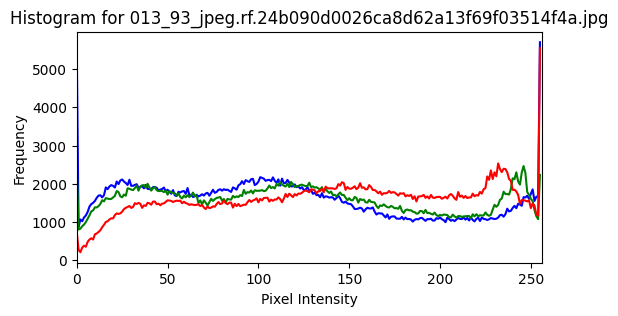

In [42]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd # Import pandas for potential future use or if needed by combined code


image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images' # Update image_directory
image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# --- Check for black or low variance images (from original cell) ---
print("--- Basic Image Quality Checks (Black/Low Variance/Color Stats) ---")
black_images = []
low_variance_images = []
color_stats = []

for img_path in image_files:
    try:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        # Check for black images
        if np.all(img == 0):
            black_images.append(img_path)

        # Check for low variance (can indicate blurriness or uniform color)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        variance = np.var(gray_img)
        if variance < 100: # Threshold can be adjusted
            low_variance_images.append((img_path, variance))

        # Collect color statistics (mean color channels)
        mean_color = np.mean(img, axis=(0, 1))
        color_stats.append(mean_color)

    except Exception as e:
        print(f"Could not process image {img_path}: {e}")

print(f"Number of black images: {len(black_images)}")
if black_images:
    print("Examples of black images:", black_images[:5])

print(f"Number of low variance images: {len(low_variance_images)}")
if low_variance_images:
    print("Examples of low variance images (path, variance):", low_variance_images[:5])

# Analyze color statistics
if color_stats:
    mean_color_per_channel = np.mean(color_stats, axis=0)
    std_color_per_channel = np.std(color_stats, axis=0)
    print(f"Average color per channel (BGR): {mean_color_per_channel}")
    print(f"Standard deviation of color per channel (BGR): {std_color_per_channel}")

print("\n" + "="*50 + "\n") # Separator for clarity

# --- Sharpness/Blur Detection (using Laplacian - from second cell) ---
print("--- Sharpness/Blur Detection (Laplacian Variance) ---")
blur_scores = []
for img_path in image_files:
    try:
        img = cv2.imread(img_path)
        if img is None:
            # Warning already printed in the previous loop iteration if loading failed
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        fm = cv2.Laplacian(gray, cv2.CV_64F).var()
        blur_scores.append((img_path, fm))
    except Exception as e:
        print(f"Could not process image for blur check {img_path}: {e}")

# Sort images by blur score (lowest variance = most blurry)
blur_scores.sort(key=lambda x: x[1])

print(f"Top 10 potentially blurriest images (path, Laplacian variance):")
for img_path, score in blur_scores[:10]:
    print(f"{img_path}: {score:.2f}")

print(f"\nTop 10 sharpest images (path, Laplacian variance):")
for img_path, score in blur_scores[-10:]:
    print(f"{img_path}: {score:.2f}")

print("\n" + "="*50 + "\n") # Separator for clarity

# --- Checking for Corrupted Images (from second cell) ---
print("--- Checking for Corrupted Images ---")
corrupted_images = []
for img_path in image_files:
    try:
        img = Image.open(img_path)
        img.verify() # Verify image integrity
    except Exception as e:
        corrupted_images.append((img_path, e))
        print(f"Corrupted image detected: {img_path} - {e}")

if not corrupted_images:
    print("No corrupted images detected using PIL.Image.verify().")
else:
    print(f"\nNumber of corrupted images found: {len(corrupted_images)}")

print("\n" + "="*50 + "\n")

# --- Analyzing Image Histograms (for a sample - from second cell) ---
print("--- Analyzing Image Histograms (Sample) ---")
sample_images_paths = image_files[:1] # Analyze histograms for the first 5 images

for img_path in sample_images_paths:
    try:
        img = cv2.imread(img_path)
        if img is None:
             # Warning already printed in the previous loop iteration if loading failed
            continue

        color = ('b','g','r')
        plt.figure(figsize=(6, 3))
        for i, col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.title(f'Histogram for {os.path.basename(img_path)}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()

    except Exception as e:
        print(f"Could not generate histogram for image {img_path}: {e}")

### Data Exploration Summary

Based on the analysis performed:

*   **Image Size Consistency:** All images have a consistent size of 640x640 pixels. This uniformity simplifies data handling.
*   **Class Distribution:** The dataset shows class imbalance, with Class 3 having significantly fewer instances (293) compared to others (ranging from 791 to 1787).
*   **Image Quality:** Images appear generally good with no detected black, severely low-variance, or corrupted files. Color distribution is relatively consistent, and there's a range of image sharpness.

The dataset is largely well-prepared regarding image size and quality. The primary characteristic to consider for subsequent model development is the **class imbalance**, particularly for Class 3, which may require strategies during model training to ensure adequate performance across all object categories. The bounding box analysis offers valuable information for understanding object properties within the images.

### Plan Step 1: Load Annotations

Load all YOLO format annotation files from the labels directory.

In [46]:
import os

annotation_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels'

all_annotations = []

if os.path.exists(annotation_directory):
    for filename in os.listdir(annotation_directory):
        if filename.lower().endswith('.txt'):
            annotation_path = os.path.join(annotation_directory, filename)
            try:
                with open(annotation_path, 'r') as f:
                    annotations_in_file = []
                    for line in f:
                        try:
                            # YOLO format: class_id center_x center_y width height (normalized)
                            class_id, center_x, center_y, bbox_width, bbox_height = map(float, line.split())
                            annotations_in_file.append({
                                'image_filename': filename.replace('.txt', '.jpg'), # Assuming corresponding image is .jpg
                                'class_id': int(class_id),
                                'center_x': center_x,
                                'center_y': center_y,
                                'bbox_width': bbox_width,
                                'bbox_height': bbox_height
                            })
                        except ValueError:
                            print(f"Skipping malformed line in {filename}: {line.strip()}")
                    if annotations_in_file:
                        all_annotations.extend(annotations_in_file)
            except Exception as e:
                print(f"Could not read annotation file {filename}: {e}")
else:
    print(f"Error: Annotation directory not found at {annotation_directory}")

print(f"Loaded {len(all_annotations)} annotations from {len(os.listdir(annotation_directory) if os.path.exists(annotation_directory) else 0)} files.")

Loaded 5948 annotations from 800 files.


## Install YOLOv8

### Subtask:
Install the Ultralytics YOLOv8 library.

**Reasoning**:
The subtask is to install the `ultralytics` library, which provides the YOLOv8 implementation. This can be done using `pip install`.

In [2]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00


### Plan Step 2 & 3: Group Annotations by Image and Analyze Class Co-occurrence

Group the loaded annotations by image filename and then check for the required class co-occurrence (Class 4, Class 0, and at least one of Class 1, 2, or 3) in each image.

In [48]:
# Group annotations by image filename
annotations_by_image = {}
for annotation in all_annotations:
    image_filename = annotation['image_filename']
    if image_filename not in annotations_by_image:
        annotations_by_image[image_filename] = []
    annotations_by_image[image_filename].append(annotation)

# Analyze class co-occurrence
images_for_training = []
required_rider_classes = {1, 2, 3} # Classes for riders (without, with valid, with invalid helmet)

for image_filename, annotations in annotations_by_image.items():
    present_classes = {annotation['class_id'] for annotation in annotations}

    # Check for required classes: Class 4, Class 0, and at least one rider class (1, 2, or 3)
    has_class_4 = 4 in present_classes
    has_class_0 = 0 in present_classes
    has_rider_class = any(rider_class in present_classes for rider_class in required_rider_classes)

    if has_class_4 and has_class_0 and has_rider_class:
        images_for_training.append(image_filename)

print(f"Total images analyzed: {len(annotations_by_image)}")
print(f"Number of images suitable for training based on co-occurrence criteria: {len(images_for_training)}")

# Optionally, print the list of suitable image filenames
# print("\nSuitable image filenames:")
# for filename in images_for_training:
#     print(filename)

Total images analyzed: 800
Number of images suitable for training based on co-occurrence criteria: 584


### Display Sample Images by Suitability for Training

Display random samples of images that are suitable and not suitable for training based on the class co-occurrence analysis.

--- Suitable Images for Training (Sample) ---


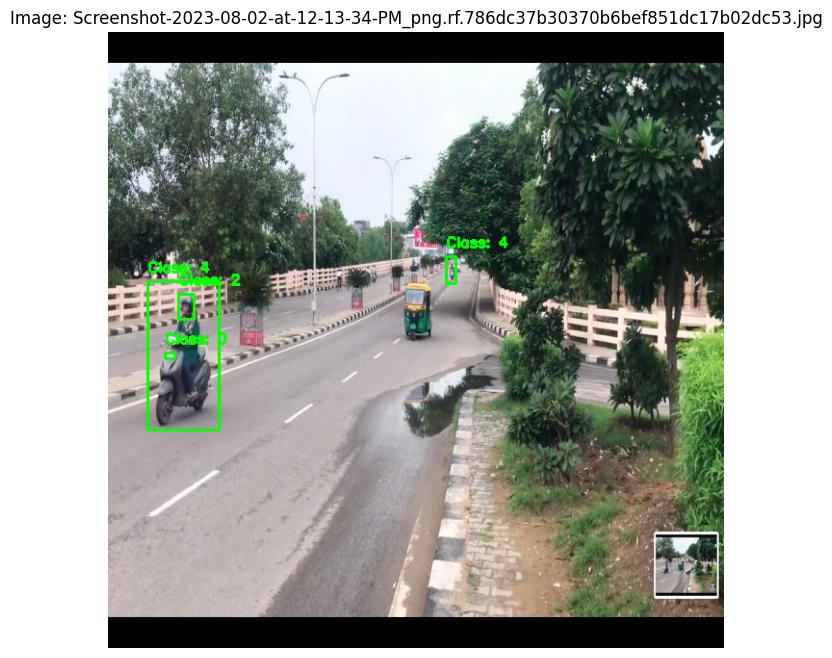

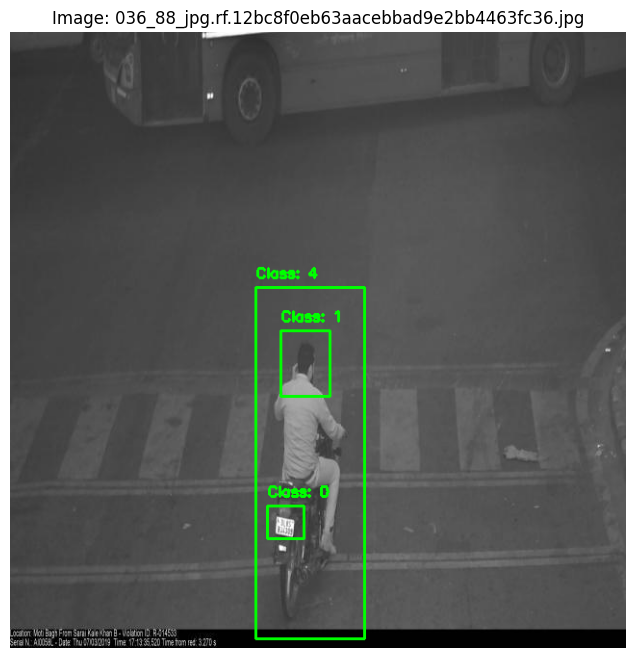

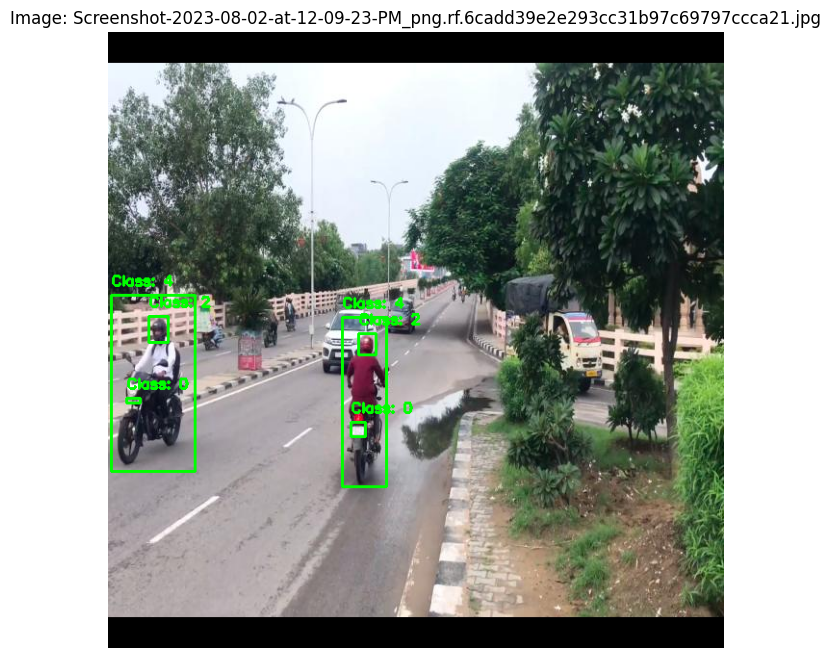


--- Not Suitable Images for Training (Sample) ---


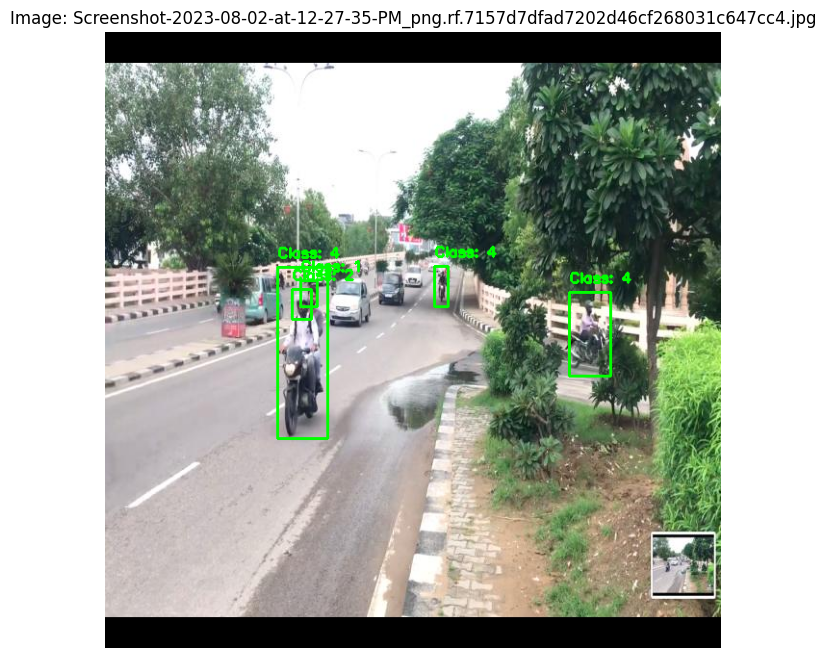

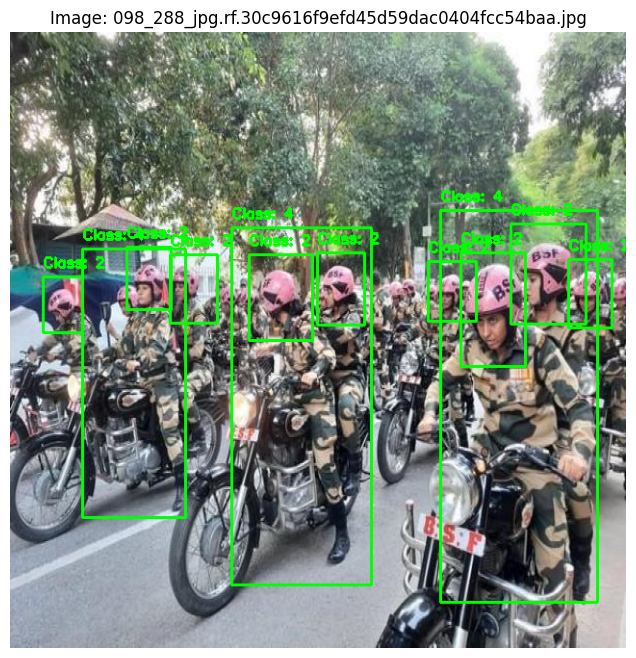

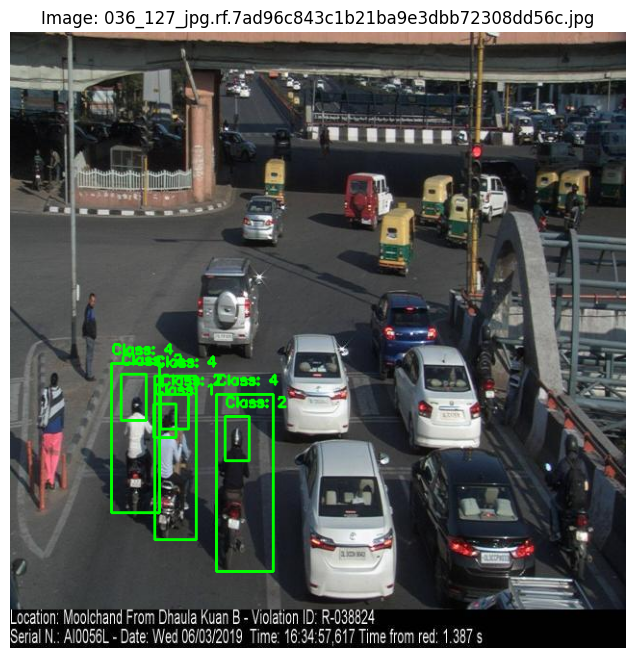

In [51]:
import os

# Assuming 'annotations_by_image' contains all image filenames and 'images_for_training' contains suitable ones
all_image_filenames = set(annotations_by_image.keys())
suitable_image_filenames = set(images_for_training)

# Identify images not suitable for training
not_suitable_image_filenames = list(all_image_filenames - suitable_image_filenames)
suitable_image_filenames_list = list(suitable_image_filenames)

# Define directories (assuming they are already defined correctly in previous cells)
image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images'
annotation_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels'

print("--- Suitable Images for Training (Sample) ---")
display_random_images_with_bboxes(suitable_image_filenames_list, image_directory, annotation_directory, num_samples=3) # Changed num_samples to 3

print("\n--- Not Suitable Images for Training (Sample) ---")
display_random_images_with_bboxes(not_suitable_image_filenames, image_directory, annotation_directory, num_samples=3) # Changed num_samples to 3

# Helmet Violation Detection from Indian CCTV Video

**Problem statement:**
Detect and flag two-wheeler helmet violations (helmetless riding) from traffic camera frames in Indian cities in real-time.

**Description:**
Create a computer vision system using YOLOv8 and object tracking to detect two-wheeler riders and classify helmet usage. Optionally perform license plate OCR for enforcement.

---

## 1. Setup and Data Loading

This section covers mounting Google Drive to access the dataset and extracting the data from the zip file.

### Mount Google Drive

Mount your Google Drive to access files stored there persistently. This is necessary because files uploaded directly to Colab's temporary storage (`/content/sample_data/`) are deleted when the runtime ends.

In [5]:
from google.colab import drive

# Mount Google Drive at /content/drive
# This will prompt you to authorize Colab to access your Google Drive files.
drive.mount('/content/drive')

# Note: Ensure your Google Drive path does not contain spaces if mounting to a custom directory.
# Mounting to the default '/content/drive' is generally recommended.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extract Dataset from Zip File

Extract the contents of the dataset zip file stored in your Google Drive to a designated folder within your Drive. This ensures the unzipped data is also persistent.

In [6]:
import zipfile
import os

# Define the path to your zip file in Google Drive
# Ensure this path correctly points to where you uploaded archive2.zip in your Drive.
zip_file_path = '/content/drive/My Drive/capstone_helmet_detection/archive2.zip'

# Define the directory within Google Drive where the contents will be extracted
# This folder will be created if it doesn't exist.
extraction_path = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified extraction_path
        zip_ref.extractall(extraction_path)
    print(f"Successfully extracted {zip_file_path} to {extraction_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
    print("Please ensure the zip file is in the correct location in your Google Drive.")
except zipfile.BadZipFile:
    print(f"Error: The file at {zip_file_path} is not a valid zip file.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Define the base directory for the extracted data based on the likely internal structure of the zip
# If the zip extracts into a subfolder like 'archive' within unzipped_archive, adjust this path.
# Based on previous successful runs, the path seems to be unzipped_archive/archive/train and unzipped_archive/archive/val
extracted_data_base_dir = os.path.join(extraction_path, 'archive')

Successfully extracted /content/drive/My Drive/capstone_helmet_detection/archive2.zip to /content/drive/My Drive/capstone_helmet_detection/unzipped_archive


## 2. Data Exploration and Analysis

This section explores the dataset's characteristics, including file counts, image sizes, class distribution, and bounding box quality.

### Count Image and Annotation Files

Count the number of image and annotation files in the extracted dataset directories to get an overview of the dataset size.

In [7]:
import os

# Define the directories for images and labels based on the extracted data path
# Adjust extracted_data_base_dir if your data structure is different
image_directory = os.path.join(extracted_data_base_dir, 'train', 'images')
annotations_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')

# Check if directories exist before listing files
if not os.path.exists(image_directory):
    print(f"Error: Image directory not found at {image_directory}")
    image_files = []
else:
    # Get a list of all files in the image directory
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not os.path.exists(annotations_dir):
    print(f"Error: Annotations directory not found at {annotations_dir}")
    annotation_files = []
else:
    # Get a list of all files in the annotations directory
    annotation_files = [f for f in os.listdir(annotations_dir) if f.lower().endswith('.txt')]


print(f"Total image files found in {image_directory}: {len(image_files)}")
print(f"Total annotation files found in {annotations_dir}: {len(annotation_files)}")

# Store the list of image files for later use
all_image_filenames = image_files

Total image files found in /content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images: 800
Total annotation files found in /content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels: 800


### Analyze Image Size Distribution

Analyze and visualize the distribution of image sizes in the dataset. This helps understand if images are of a consistent size or vary, which can impact model training.

Image Size Distribution Statistics:
       Width  Height
count  800.0   800.0
mean   640.0   640.0
std      0.0     0.0
min    640.0   640.0
25%    640.0   640.0
50%    640.0   640.0
75%    640.0   640.0
max    640.0   640.0


<Figure size 800x800 with 0 Axes>

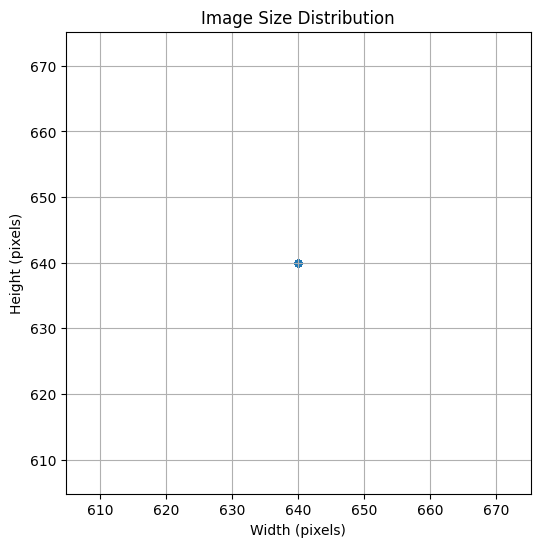

In [8]:
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define the directory containing the images
# Uses the image_directory defined in the previous cell
# image_directory = os.path.join(extracted_data_base_dir, 'train', 'images')

# Get a list of all image file paths
all_image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sizes = []
# Iterate through image paths and get their sizes
# Using a limit of 800 as seen in previous runs, adjust if needed
for img_path in all_image_paths[:800]:
    try:
        with Image.open(img_path) as img:
            sizes.append(img.size)
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")


# Create a DataFrame from the collected sizes
df_sizes = pd.DataFrame(sizes, columns=["Width", "Height"])

# Print descriptive statistics of the image sizes
print("Image Size Distribution Statistics:")
print(df_sizes.describe())

# Plot the image size distribution as a scatter plot
plt.figure(figsize=(8, 8))
df_sizes.plot(kind="scatter", x="Width", y="Height", alpha=0.5, figsize=(6,6))
plt.title("Image Size Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.show()

### Analyze Class Distribution

Analyze the distribution of object classes within the dataset's annotations. This helps identify class imbalance, which might require specific handling during model training.

In [9]:
import os

# Define the directory containing the annotation files
# Uses the annotations_dir defined previously
# annotations_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')

# Dictionary to store class counts
class_counts = {}

# Iterate through each annotation file
if os.path.exists(annotations_dir):
    for filename in os.listdir(annotations_dir):
        # Process only .txt files (assuming YOLO format annotations)
        if filename.lower().endswith('.txt'):
            annotation_path = os.path.join(annotations_dir, filename)
            try:
                # Read each line in the annotation file
                with open(annotation_path, 'r') as f:
                    for line in f:
                        try:
                            # The first value in each line is the class_id (YOLO format)
                            class_id = int(line.split()[0])
                            # Increment the count for this class_id
                            if class_id in class_counts:
                                class_counts[class_id] += 1
                            else:
                                class_counts[class_id] = 1
                        except (ValueError, IndexError):
                            # Handle lines that might not be in the expected format
                            print(f"Skipping malformed line in {filename}: {line.strip()}")
            except Exception as e:
                print(f"Could not read annotation file {filename}: {e}")
else:
    print(f"Error: Annotations directory not found at {annotations_dir}")


# Print the class distribution
print("Class distribution across all annotations:")
# Sort by class ID for consistent output
for class_id in sorted(class_counts.keys()):
    print(f"Class {class_id}: {class_counts[class_id]}")

# Store class counts for later use if needed
# class_counts_dict = class_counts

Class distribution across all annotations:
Class 0: 1327
Class 1: 791
Class 2: 1787
Class 3: 293
Class 4: 1750


### Define Class Names

Based on manual inspection or dataset documentation, define the mapping of class IDs to human-readable names. This is crucial for interpreting results and configuring YOLOv8.

In [10]:
# Define the class names based on the mapping you provided:
# 0 → Vehicle number
# 1 → Rider without helmet
# 2 → Rider with valid helmet
# 3 → Rider with invalid helmet
# 4 → Motorbike with a person

class_names = ['Vehicle number', 'Rider without helmet', 'Rider with valid helmet', 'Rider with invalid helmet', 'Motorbike with a person']
num_classes = len(class_names) # Number of classes

print("Defined class names:")
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")

# Store class names and number of classes for later use
# class_names_list = class_names
# num_classes_int = num_classes

Defined class names:
Class 0: Vehicle number
Class 1: Rider without helmet
Class 2: Rider with valid helmet
Class 3: Rider with invalid helmet
Class 4: Motorbike with a person


### Visualize Sample Images with Bounding Boxes

Define a function to display random images with their corresponding bounding boxes and class labels drawn on them. This is useful for visually inspecting annotations and understanding the data.

In [11]:
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display random images with bounding boxes from a given list of filenames
# Assumes class_names list is available in the environment
def display_random_images_with_bboxes(image_filenames, image_directory, annotation_directory, num_samples=5):
    """
    Displays random images with bounding boxes from a list of filenames.

    Args:
        image_filenames (list): A list of image filenames to choose from.
        image_directory (str): The directory where the images are located.
        annotation_directory (str): The directory where the annotation files are located.
        num_samples (int): The number of random images to display.
    """
    if not image_filenames:
        print("No image files provided in the list.")
        return

    # Select random image files from the provided list
    num_samples = min(num_samples, len(image_filenames)) # Ensure we don't ask for more samples than available
    random_image_filenames = random.sample(image_filenames, num_samples)

    for image_filename in random_image_filenames:
        image_path = os.path.join(image_directory, image_filename)
        # Assuming annotation filename has the same base name as the image with a .txt extension
        annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
        annotation_path = os.path.join(annotation_directory, annotation_filename)

        # Load the image using PIL and convert to OpenCV format
        # Using PIL as cv2.imread sometimes had issues with mounted Drive paths
        try:
            pil_image = Image.open(image_path)
            # Convert PIL image to NumPy array (BGR format for OpenCV)
            image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
            h, w, _ = image.shape
        except Exception as e:
            print(f"Could not load or process image {image_path}: {e}")
            image = None # Set image to None if loading fails

        # Read the annotation file and draw bounding boxes
        if image is not None and os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                for line in f:
                    try:
                        # YOLO format: class_id center_x center_y width height (normalized)
                        parts = line.split()
                        if len(parts) < 5:
                             print(f"Skipping incomplete annotation line in {annotation_filename}: {line.strip()}")
                             continue
                        class_id = int(parts[0])
                        center_x, center_y, bbox_width, bbox_height = map(float, parts[1:5])

                        # Convert normalized coordinates to pixel coordinates
                        x_center = int(center_x * w)
                        y_center = int(center_y * h)

                        box_w = int(bbox_width * w)
                        box_h = int(bbox_height * h)

                        # Calculate top-left corner coordinates
                        x_min = int(x_center - box_w / 2)
                        y_min = int(y_center - box_h / 2)
                        x_max = int(x_center + box_w / 2)
                        y_max = int(y_center + box_h / 2)

                        # Draw bounding box (Green color, thickness 2)
                        # You can define colors per class if needed
                        color = (0, 255, 0) # Green

                        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

                        # Put class label (using defined class_names if available)
                        label = f"Class: {class_id}"
                        if 'class_names' in globals() and class_id < len(class_names):
                            label = class_names[class_id]

                        # Position the text slightly above the top-left corner
                        text_x = x_min
                        text_y = y_min - 10 # 10 pixels above the box

                        # Ensure text does not go out of image bounds
                        if text_y < 0:
                           text_y = y_min + 15 # Position below if needed


                        cv2.putText(image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA) # Increased font size slightly


                    except Exception as e:
                        print(f"Could not process annotation line in {annotation_filename}: {line.strip()} - {e}")


            # Display the image (using matplotlib)
            # Convert BGR image to RGB for matplotlib display
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10)) # Adjust figure size for better viewing
            plt.imshow(image_rgb)
            plt.title(f"Image: {image_filename}")
            plt.axis('off') # Hide axes ticks and labels
            plt.show()


        elif image is None:
            print(f"Skipping {image_filename} due to loading error.")
        else:
            print(f"Annotation file not found for {image_filename} at {annotation_path}")

# This cell now defines the function. Call this function from another cell to display images.

### Analyze Class Co-occurrence and Display Samples

Analyze the co-occurrence of specific classes in the dataset to identify images suitable for training based on defined criteria. Then, display sample images from both suitable and unsuitable categories.

In [12]:
# Assuming all_annotations list is available from loading annotations
# Assuming annotations_by_image dictionary is available from grouping annotations

# Group annotations by image filename (if not already done)
# This is a repeat from a previous analysis step, kept here for notebook flow
annotations_by_image = {}
for annotation in all_annotations:
    image_filename = annotation['image_filename']
    if image_filename not in annotations_by_image:
        annotations_by_image[image_filename] = []
    annotations_by_image[image_filename].append(annotation)


# Analyze class co-occurrence based on your criteria:
# Images must contain Class 4 (Motorbike with a person), Class 0 (Vehicle number),
# AND at least one of the rider classes (1: Rider without helmet, 2: Rider with valid helmet, 3: Rider with invalid helmet)
images_for_training = []
required_rider_classes = {1, 2, 3} # Set of class IDs for riders

for image_filename, annotations in annotations_by_image.items():
    # Get the set of unique class IDs present in the current image's annotations
    present_classes = {annotation['class_id'] for annotation in annotations}

    # Check for the required classes
    has_class_4 = 4 in present_classes
    has_class_0 = 0 in present_classes
    # Check if any of the rider classes are present
    has_rider_class = any(rider_class in present_classes for rider_class in required_rider_classes)

    # If all criteria are met, add the image filename to the list of suitable images
    if has_class_4 and has_class_0 and has_rider_class:
        images_for_training.append(image_filename)

print(f"Total images analyzed for co-occurrence: {len(annotations_by_image)}")
print(f"Number of images suitable for training based on co-occurrence criteria: {len(images_for_training)}")

# Identify images not suitable for training (all images minus suitable ones)
all_image_filenames_set = set(annotations_by_image.keys())
suitable_image_filenames_set = set(images_for_training)
not_suitable_image_filenames = list(all_image_filenames_set - suitable_image_filenames_set)
suitable_image_filenames_list = list(suitable_image_filenames_set) # Convert set back to list for sampling


# Display sample images from both categories
print("\n--- Suitable Images for Training (Sample) ---")
# Display 3 random samples from the suitable images list
display_random_images_with_bboxes(suitable_image_filenames_list, image_directory, annotations_dir, num_samples=3)

print("\n--- Not Suitable Images for Training (Sample) ---")
# Display 3 random samples from the not suitable images list
display_random_images_with_bboxes(not_suitable_image_filenames, image_directory, annotations_dir, num_samples=3)

NameError: name 'all_annotations' is not defined

### Perform Annotation Quality Check

Analyze the quality of bounding box annotations by checking for very small boxes and boxes that extend outside the image boundaries.

In [13]:
import os

# Assuming annotations_by_image dictionary is available from grouping annotations
# Assuming image_directory is defined

print("--- Annotation Quality Check ---")

very_small_boxes = []
boxes_outside_image = []

# Define a threshold for "very small" boxes in pixels (e.g., less than 10x10 pixels)
# Adjust this threshold based on your specific requirements and dataset
small_box_threshold_width = 10  # pixels
small_box_threshold_height = 10 # pixels

# Assuming all images have a consistent size based on previous analysis (e.g., 640x640)
# If image sizes vary, you would need to load each image to get its dimensions here.
# For this dataset, analysis in Step 2.2 confirmed all images are 640x640.
image_width = 640
image_height = 640

# Iterate through annotations grouped by image
for image_filename, annotations in annotations_by_image.items():
    for annotation in annotations:
        class_id = annotation['class_id']
        center_x_norm = annotation['center_x']
        center_y_norm = annotation['center_y']
        bbox_width_norm = annotation['bbox_width']
        bbox_height_norm = annotation['bbox_height']

        # Convert normalized coordinates to pixel coordinates
        # Ensure calculations handle potential floating point inaccuracies
        x_center = int(round(center_x_norm * image_width))
        y_center = int(round(center_y_norm * image_height))
        box_w = int(round(bbox_width_norm * image_width))
        box_h = int(round(bbox_height_norm * image_height))

        # Calculate top-left and bottom-right corner coordinates in pixels
        x_min = int(x_center - box_w / 2)
        y_min = int(y_center - box_h / 2)
        x_max = int(x_center + box_w / 2)
        y_max = int(y_center + box_h / 2)

        # Check for very small boxes based on the defined threshold
        if box_w < small_box_threshold_width or box_h < small_box_threshold_height:
            very_small_boxes.append({
                'image_filename': image_filename,
                'class_id': class_id,
                'width_pixels': box_w,
                'height_pixels': box_h,
                'bbox_norm': (center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm)
            })

        # Check for boxes outside image boundaries
        # Check if any corner or edge is outside the [0, image_width) or [0, image_height) range
        if x_min < -1 or y_min < -1 or x_max > image_width + 1 or y_max > image_height + 1: # Add a small buffer for floating point
             boxes_outside_image.append({
                'image_filename': image_filename,
                'class_id': class_id,
                'x_min': x_min,
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max,
                'bbox_norm': (center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm)
            })

# Report findings on very small boxes
print(f"Number of very small boxes found (threshold: {small_box_threshold_width}x{small_box_threshold_height} pixels): {len(very_small_boxes)}")
if very_small_boxes:
    print("Examples of very small boxes:")
    # Print first 5 examples
    for i, box_info in enumerate(very_small_boxes[:5]):
        print(f"  Image: {box_info['image_filename']}, Class: {box_info['class_id']}, Size: {box_info['width_pixels']}x{box_info['height_pixels']}")

# Report findings on boxes outside image boundaries
print(f"\nNumber of boxes outside image boundaries found: {len(boxes_outside_image)}")
if boxes_outside_image:
    print("Examples of boxes outside image boundaries:")
    # Print first 5 examples
    for i, box_info in enumerate(boxes_outside_image[:5]):
         print(f"  Image: {box_info['image_filename']}, Class: {box_info['class_id']}, Bbox Pixels: ({box_info['x_min']}, {box_info['y_min']}, {box_info['x_max']}, {box_info['y_max']})")

# Note: This check assumes all images are 640x640 as found in previous analysis.
# If image sizes vary, you would need to load each image to get its dimensions.

--- Annotation Quality Check ---
Number of very small boxes found (threshold: 10x10 pixels): 0

Number of boxes outside image boundaries found: 0


### Display Sample Image with Very Small Boxes

Display a sample image that contains one or more very small bounding boxes to visually assess the issue.

In [14]:
# Assuming very_small_boxes list is available from the previous quality check cell
# Assuming display_random_images_with_bboxes function is defined

if very_small_boxes:
    # Get the filename of the first image identified as having a very small box
    sample_image_filename = very_small_boxes[0]['image_filename']

    # Define directories (assuming they are already defined correctly)
    # image_directory = os.path.join(extracted_data_base_dir, 'train', 'images')
    # annotations_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')


    print(f"--- Displaying a sample image with very small boxes: {sample_image_filename} ---")

    # Use the display function to show this specific image.
    # The function will draw all bboxes for this image, including the small ones.
    display_random_images_with_bboxes([sample_image_filename], image_directory, annotations_dir, num_samples=1)
else:
    print("No very small boxes were found, so no sample image can be displayed.")

No very small boxes were found, so no sample image can be displayed.


---

## 3. Data Augmentation

This section focuses on applying data augmentation techniques to the dataset to increase its size and variability, which can help improve model performance, especially for detecting small objects and addressing class imbalance.

### Install Augmentation Library

Install a suitable data augmentation library for object detection (e.g., Albumentations) and its dependencies.

In [15]:
# Install Albumentations and opencv-python-headless
# opencv-python-headless is used by Albumentations for image processing
%pip install albumentations opencv-python-headless

# Note: You might need to restart the runtime after installation if prompted.

### Define Augmentation Pipeline

Define a sequence of image and bounding box transformations to apply for data augmentation using the `albumentations` library.

In [16]:
import albumentations as A
import cv2 # Import cv2 as it's needed for some Albumentations border modes

# Define a list of class IDs. This is used by Albumentations to correctly transform bounding box labels.
# Assumes class_names list is already defined, getting the number of classes from it.
class_ids_list = list(range(num_classes)) # [0, 1, 2, 3, 4]

# Define the augmentation pipeline based on your requested techniques
augmentation_pipeline = A.Compose([
    # Image resizing and multi-scale augmentation (zoom, resize jitter, overlapping crops)
    # RandomSizedBBoxSafeCrop crops a random part of the image and resizes it.
    # This helps with scale variation and makes small objects appear larger in the crop.
    # Using target size 640x640 to match expected model input size.
    A.RandomSizedBBoxSafeCrop(
        min_max_height=(480, 800), # Example range for random crop height before resizing
        width=640, # Target output width after cropping and resizing
        height=640, # Target output height after cropping and resizing
        p=0.7 # Probability of applying this transform
    ),

    # Horizontal flip: Flips the image and bounding boxes horizontally. Useful for many datasets.
    A.HorizontalFlip(p=0.5),

    # Rotation: Rotates the image and bounding boxes by a limited angle.
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Rotate by up to 10 degrees, fill borders with black


    # Color normalization (HSV jitter), brightness, contrast, saturation adjustments
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.7), # Adjust brightness, contrast, saturation, hue

    # Hierarchical contrast (CLAHE) and sharpness/emboss effects for edge-based variations
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5), # Apply CLAHE for local contrast enhancement
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.3), # Apply sharpening
    A.Emboss(alpha=(0.1, 0.3), strength=(0.5, 1.0), p=0.3), # Apply emboss effect
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Additional random brightness/contrast

    # Geometric transformations: Small shifts and scales
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Small shifts and scales, no rotation here as it's done above

    # Adding some noise and blur for robustness to image quality variations
    A.GaussNoise(p=0.3), # Add Gaussian noise
    A.GaussianBlur(blur_limit=(3, 7), p=0.3), # Apply Gaussian blur


], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])) # Specify YOLO format for bounding boxes and the field containing labels

print("Augmentation pipeline defined successfully with requested techniques.")

Augmentation pipeline defined successfully with requested techniques.


/tmp/ipython-input-155332642.py:14: UserWarning: Argument(s) 'min_max_height' are not valid for transform RandomSizedBBoxSafeCrop
  A.RandomSizedBBoxSafeCrop(
/tmp/ipython-input-155332642.py:25: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Rotate by up to 10 degrees, fill borders with black
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-155332642.py:38: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Small shifts and scales, no rotation here as it's done above


### Implement Augmentation Function

Create a Python function that takes an image and its annotations, applies the defined augmentation pipeline, and returns the augmented data.

In [17]:
import numpy as np
import cv2
import albumentations as A # Ensure A is imported

# Assuming augmentation_pipeline is defined in the previous cell

def apply_augmentation(image, annotations):
    """
    Applies the defined augmentation pipeline to an image and its bounding boxes.

    Args:
        image (np.ndarray): The input image as a NumPy array (H, W, C), expected in BGR format.
        annotations (list): A list of bounding box annotations in YOLO format.
                           Each annotation is a list or tuple: [class_id, center_x, center_y, width, height].

    Returns:
        tuple: A tuple containing:
               - augmented_image (np.ndarray): The augmented image (in BGR format).
               - augmented_annotations (list): A list of augmented bounding box annotations in YOLO format.
                                               Each annotation is a list: [class_id, center_x, center_y, width, height].
               Returns (None, None) if augmentation fails.
    """
    # Albumentations expects bounding boxes in a specific format for 'yolo':
    # list of tuples: (x_center, y_center, width, height)
    # And coordinates should be normalized (0 to 1)
    # The class_id is passed separately using the 'class_labels' parameter.

    bboxes = []
    bbox_class_labels = [] # List to store class labels corresponding to each bbox

    for annot in annotations:
        # Ensure annotation is in the correct format and contains enough values
        if len(annot) >= 5:
            # Extract class_id and normalized bbox coordinates
            class_id = int(annot[0])
            center_x, center_y, bbox_width, bbox_height = annot[1:5]

            # Append bbox in the format expected by Albumentations (x_c, y_c, w, h)
            bboxes.append([center_x, center_y, bbox_width, bbox_height])
            # Store the class_id for this bbox
            bbox_class_labels.append(class_id)
        else:
            print(f"Warning: Skipping malformed annotation: {annot}")

    # Apply the augmentation pipeline
    # The image should be in RGB format for Albumentations
    try:
        # Ensure image is not None before converting color
        if image is None:
            print("Error: Input image is None.")
            return None, None

        augmented = augmentation_pipeline(
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB), # Convert BGR input to RGB for Albumentations
            bboxes=bboxes,
            class_labels=bbox_class_labels # Pass the list of class labels for each bbox
        )
    except Exception as e:
        print(f"Error during augmentation pipeline application: {e}")
        # Return None, None if augmentation fails for this image
        return None, None


    # Extract augmented image and bounding boxes
    augmented_image = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR) # Convert augmented RGB image back to BGR
    augmented_bboxes_alb = augmented['bboxes']
    augmented_class_labels_output = augmented['class_labels']


    # Convert augmented bounding boxes back to YOLO format [class_id, center_x, center_y, width, height]
    augmented_annotations = []
    for bbox_alb, class_lbl in zip(augmented_bboxes_alb, augmented_class_labels_output):
         # Ensure bbox_alb has 4 elements (x_c, y_c, w, h)
        if len(bbox_alb) >= 4:
            # Albumentations returns [x_c, y_c, w, h] for yolo format
            augmented_annotations.append([int(class_lbl), bbox_alb[0], bbox_alb[1], bbox_alb[2], bbox_alb[3]])
        else:
            print(f"Warning: Skipping malformed augmented bounding box: {bbox_alb} with class label {class_lbl}")


    return augmented_image, augmented_annotations

print("Augmentation function defined successfully.")

Augmentation function defined successfully.


### Apply Augmentation to Dataset

Iterate through the images suitable for training, apply the augmentation function multiple times to each, and save the augmented images and their updated annotation files.

In [18]:
import os
import cv2
import numpy as np
from PIL import Image # Import PIL for image loading
# Assuming apply_augmentation function is defined
# Assuming images_for_training list is available from co-occurrence analysis
# Assuming image_directory and annotations_dir are defined (pointing to original data)


# Define the output base directory for augmented data within Google Drive
augmented_output_base_dir = '/content/drive/My Drive/capstone_helmet_detection/augmented_data'

# Define the output directories for augmented images and labels
augmented_images_dir = os.path.join(augmented_output_base_dir, 'images')
augmented_labels_dir = os.path.join(augmented_output_base_dir, 'labels')

# Create output directories if they don't exist
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

# Number of augmented samples to generate per original image
# Adjust this number based on how much you want to increase your dataset size
num_augmentations_per_image = 3

print(f"Starting data augmentation. Augmented data will be saved to: {augmented_output_base_dir}")

augmented_image_count = 0
augmented_annotation_count = 0

# Iterate through the list of images previously identified as suitable for training
# This ensures we only augment images that meet your co-occurrence criteria
for image_filename in images_for_training:
    original_image_path = os.path.join(image_directory, image_filename)
    # Assuming original annotation filename has the same base name as the image with a .txt extension
    original_annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
    original_annotation_path = os.path.join(annotations_dir, original_annotation_filename)

    # Check if annotation file exists for the original image
    if not os.path.exists(original_annotation_path):
        print(f"Skipping image {image_filename}: Original annotation file not found at {original_annotation_path}.")
        continue

    # Load the original image using PIL (as cv2.imread sometimes had issues)
    try:
        pil_image = Image.open(original_image_path)
        original_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR) # Convert PIL to OpenCV BGR format
    except Exception as e:
        print(f"Skipping image {image_filename} due to loading error from {original_image_path}: {e}")
        continue

    # Load original annotations for the image
    original_annotations = []
    try:
        with open(original_annotation_path, 'r') as f:
            for line in f:
                try:
                    # Parse YOLO format: class_id center_x center_y width height (normalized)
                    parts = line.split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        center_x, center_y, bbox_width, bbox_height = map(float, parts[1:5])
                        original_annotations.append([class_id, center_x, center_y, bbox_width, bbox_height])
                    else:
                         print(f"Skipping malformed annotation line in {original_annotation_filename}: {line.strip()}")
                except ValueError:
                    print(f"Skipping malformed annotation line (ValueError) in {original_annotation_filename}: {line.strip()}")
    except Exception as e:
        print(f"Skipping image {image_filename}: Could not read original annotation file from {original_annotation_path}: {e}")
        continue

    # Skip augmentation if no valid annotations were loaded for the image
    if not original_annotations:
        print(f"Skipping augmentation for {image_filename}: No valid annotations found.")
        continue


    # Apply augmentation multiple times to generate augmented samples
    for i in range(num_augmentations_per_image):
        try:
            # Apply the augmentation pipeline using the function
            augmented_image, augmented_annotations = apply_augmentation(
                original_image.copy(), # Pass a copy to avoid modifying the original image
                original_annotations.copy() # Pass a copy of annotations
                # class_labels is handled internally by apply_augmentation now
            )

            # Only process and save if augmentation was successful and returned data
            if augmented_image is not None and augmented_annotations is not None:

                # Generate unique filename for the augmented image and annotation
                base_filename = os.path.splitext(image_filename)[0]
                # Example naming: original_filename_aug_iteration.jpg/txt
                augmented_image_filename = f"{base_filename}_aug_{i}.jpg"
                augmented_annotation_filename = f"{base_filename}_aug_{i}.txt"

                output_image_path = os.path.join(augmented_images_dir, augmented_image_filename)
                output_annotation_path = os.path.join(augmented_labels_dir, augmented_annotation_filename)

                # Save the augmented image
                cv2.imwrite(output_image_path, augmented_image)
                augmented_image_count += 1

                # Save the augmented annotations in YOLO format
                with open(output_annotation_path, 'w') as f:
                    for annot in augmented_annotations:
                        # Write in YOLO format: class_id center_x center_y width height (normalized)
                        # Ensure data types and formatting are correct (float for coords/size with sufficient precision)
                        f.write(f"{int(annot[0])} {annot[1]:.6f} {annot[2]:.6f} {annot[3]:.6f} {annot[4]:.6f}\n")
                    augmented_annotation_count += len(augmented_annotations) # Count individual annotations

        except Exception as e:
            print(f"Error augmenting or saving image {image_filename} iteration {i}: {e}")
            # Continue to the next iteration or image even if one fails


print("-" * 50)
print(f"Data augmentation process finished.")
print(f"Generated {augmented_image_count} augmented images.")
print(f"Generated {augmented_annotation_count} augmented bounding box annotations.")

Starting data augmentation. Augmented data will be saved to: /content/drive/My Drive/capstone_helmet_detection/augmented_data


NameError: name 'images_for_training' is not defined

### Verify Augmented Data (Optional)

It's a good practice to visualize some of the augmented images with their new bounding boxes to ensure the augmentation pipeline is working as expected and bounding boxes are correctly transformed.

--- Displaying Sample Augmented Images ---


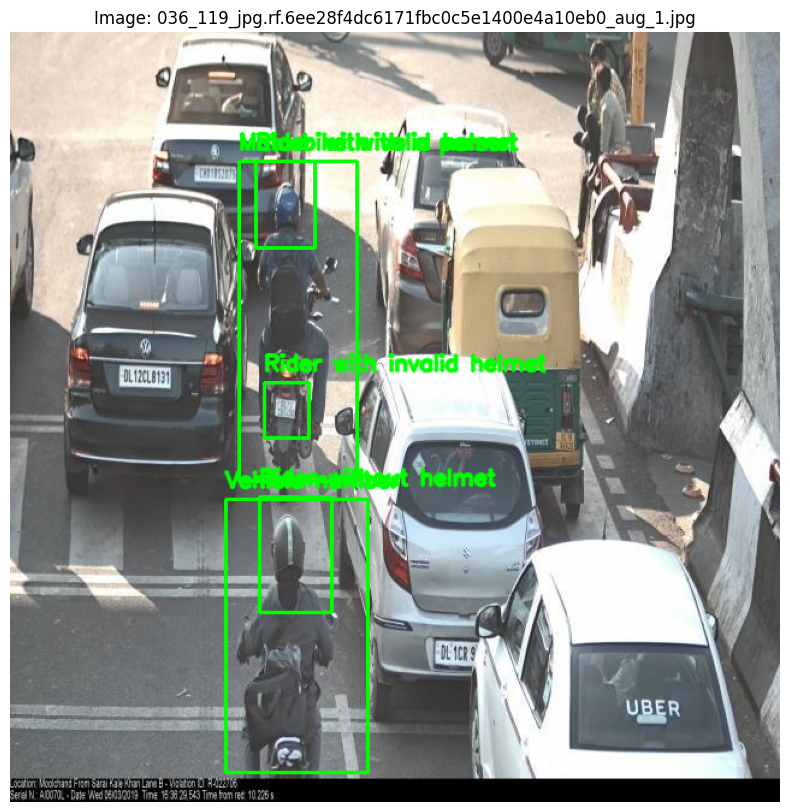

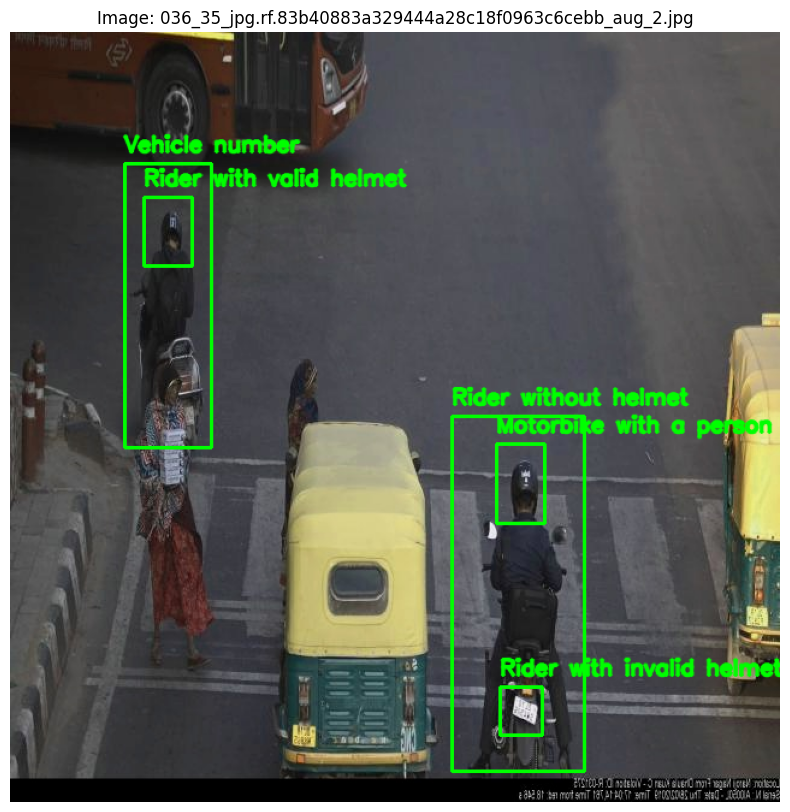

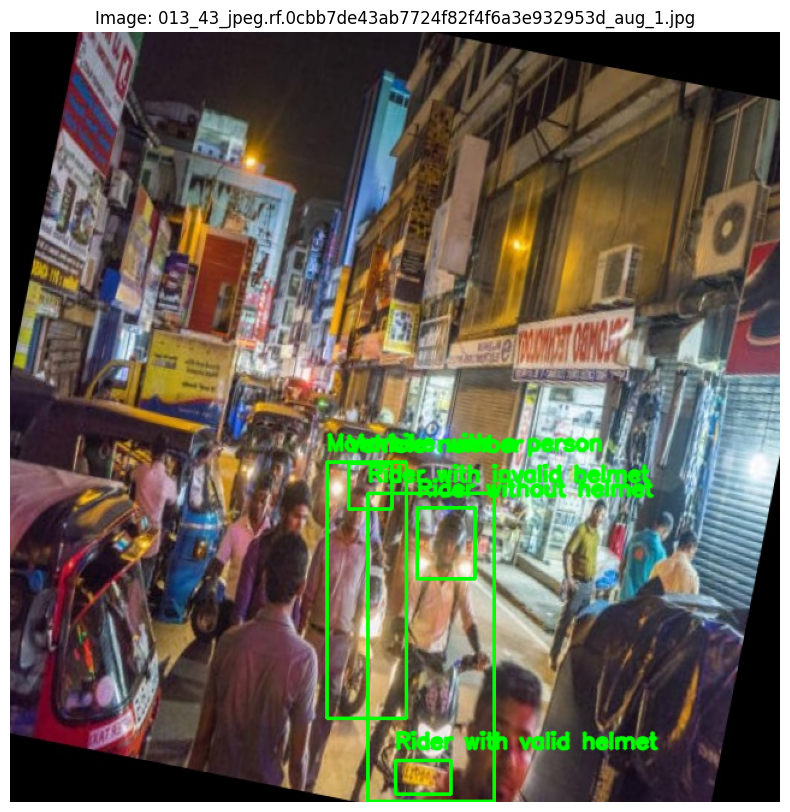

In [19]:
import os
# Assuming display_random_images_with_bboxes function is defined
# Assuming augmented_images_dir and augmented_labels_dir are defined

print("--- Displaying Sample Augmented Images ---")

# Get a list of augmented image filenames
if os.path.exists(augmented_images_dir):
    augmented_image_filenames = [f for f in os.listdir(augmented_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
else:
    print(f"Augmented images directory not found at {augmented_images_dir}")
    augmented_image_filenames = []

# Display a sample of augmented images
if augmented_image_filenames:
    # Display 3 random samples from the augmented images
    display_random_images_with_bboxes(augmented_image_filenames, augmented_images_dir, augmented_labels_dir, num_samples=3)
else:
    print("No augmented images found to display.")

---

## 4. Data Preparation for YOLOv8 Training

This section prepares the dataset in the specific directory structure required by YOLOv8, combining original (for validation) and augmented (for training) data.

### Organize Data Directories and Split Dataset

Create the necessary directory structure for YOLOv8 (`train`, `val`) and copy the original dataset (splitting into train/validation) and the augmented dataset (for training) into these directories.

In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths to original data and augmented data based on previous steps
# extracted_data_base_dir should point to the root of your unzipped archive structure
# augmented_output_base_dir should point to where augmented data was saved

original_images_dir = os.path.join(extracted_data_base_dir, 'train', 'images')
original_labels_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')
augmented_images_dir = os.path.join(augmented_output_base_dir, 'images')
augmented_labels_dir = os.path.join(augmented_output_base_dir, 'labels')


# Define the base directory for the new YOLOv8 format dataset structure
yolov8_data_base_dir = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset_prepared' # Using a new dir name to avoid overwriting previous attempts

# Define the directories for the YOLOv8 training structure
train_img_dir_yolo = os.path.join(yolov8_data_base_dir, 'train', 'images')
train_label_dir_yolo = os.path.join(yolov8_data_base_dir, 'train', 'labels')
val_img_dir_yolo = os.path.join(yolov8_data_base_dir, 'val', 'images')
val_label_dir_yolo = os.path.join(yolov8_data_base_dir, 'val', 'labels')
# Test set is optional for now, we will just use train and val

# Create the new YOLOv8 format directories
os.makedirs(train_img_dir_yolo, exist_ok=True)
os.makedirs(train_label_dir_yolo, exist_ok=True)
os.makedirs(val_img_dir_yolo, exist_ok=True)
os.makedirs(val_label_dir_yolo, exist_ok=True)

print("Created YOLOv8 dataset directory structure.")

# Get list of original image filenames
# Assuming images and labels have the same base name and are in the train folder of original data
if os.path.exists(original_images_dir):
    original_image_files = [f for f in os.listdir(original_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
else:
    print(f"Error: Original images directory not found at {original_images_dir}. Cannot split data.")
    original_image_files = []

# Split original data into training and validation sets (e.g., 80/20 split)
# We use the original data for the validation set to evaluate on unseen, non-augmented data.
# A portion of original data is also used in the training set before adding augmented data.
if original_image_files:
    train_files_orig, val_files_orig = train_test_split(original_image_files, test_size=0.2, random_state=42) # 80% train, 20% val
    print(f"Original images found: {len(original_image_files)}")
    print(f"Original images allocated for YOLOv8 train split: {len(train_files_orig)}")
    print(f"Original images allocated for YOLOv8 val split: {len(val_files_orig)}")

    # Copy original training data split to the new YOLOv8 train directories
    print("\nCopying original training data split...")
    for filename in train_files_orig:
        base_filename = os.path.splitext(filename)[0]
        img_src = os.path.join(original_images_dir, filename)
        label_src = os.path.join(original_labels_dir, base_filename + '.txt')
        img_dst = os.path.join(train_img_dir_yolo, filename)
        label_dst = os.path.join(train_label_dir_yolo, base_filename + '.txt')
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_src, label_dst)
        elif os.path.exists(img_src):
             print(f"Warning: Label file not found for original train image {filename}. Skipping copy.")
        else:
             print(f"Warning: Original train image {filename} not found. Skipping copy.")

    print("Finished copying original training data split.")

    # Copy original validation data split to the new YOLOv8 val directories
    print("\nCopying original validation data split...")
    for filename in val_files_orig:
        base_filename = os.path.splitext(filename)[0]
        img_src = os.path.join(original_images_dir, filename)
        label_src = os.path.join(original_labels_dir, base_filename + '.txt')
        img_dst = os.path.join(val_img_dir_yolo, filename)
        label_dst = os.path.join(val_label_dir_yolo, base_filename + '.txt')
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_src, label_dst)
        elif os.path.exists(img_src):
             print(f"Warning: Label file not found for original val image {filename}. Skipping copy.")
        else:
             print(f"Warning: Original val image {filename} not found. Skipping copy.")
    print("Finished copying original validation data split.")

else:
    print("No original images found. Skipping data splitting and copying original data.")


# Copy augmented data to the new YOLOv8 train directories
# Augmented data is typically only used for training
print("\nCopying augmented data to train directory...")
if os.path.exists(augmented_images_dir):
    augmented_image_files = [f for f in os.listdir(augmented_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Augmented images found: {len(augmented_image_files)}")
    for filename in augmented_image_files:
        base_filename = os.path.splitext(filename)[0]
        img_src = os.path.join(augmented_images_dir, filename)
        label_src = os.path.join(augmented_labels_dir, base_filename + '.txt')
        img_dst = os.path.join(train_img_dir_yolo, filename)
        label_dst = os.path.join(train_label_dir_yolo, base_filename + '.txt')
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_dst, label_dst) # Corrected: copy label_src to label_dst
        elif os.path.exists(img_src):
             print(f"Warning: Label file not found for augmented image {filename}. Skipping copy.")
        else:
             print(f"Warning: Augmented image {filename} not found. Skipping copy.")

    print("Finished copying augmented data.")
else:
    print(f"Augmented images directory not found at {augmented_images_dir}. Skipping copying augmented data.")


print("\nData preparation for YOLOv8 training complete.")

# Store paths to the prepared dataset directories for data.yaml
yolov8_train_img_path = train_img_dir_yolo
yolov8_val_img_path = val_img_dir_yolo
# yolov8_test_img_path = test_img_dir_yolo # If using a test set

Created YOLOv8 dataset directory structure.
Original images found: 800
Original images allocated for YOLOv8 train split: 640
Original images allocated for YOLOv8 val split: 160

Copying original training data split...
Finished copying original training data split.

Copying original validation data split...
Finished copying original validation data split.

Copying augmented data to train directory...
Augmented images found: 129


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset_prepared/train/labels/Screenshot-2023-08-02-at-12-12-36-PM_png.rf.ca7f0f7b181e20a5637e35df69b9459b_aug_0.txt'

### Create data.yaml File

Create the `data.yaml` configuration file for YOLOv8. This file specifies the paths to the training and validation datasets and the names of the classes.

In [21]:
import yaml
import os

# Define the base directory for the prepared YOLOv8 dataset
# Uses yolov8_data_base_dir defined in the previous cell
# yolov8_data_base_dir = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset_prepared'

# Define the paths for training and validation images relative to the base directory
# Uses paths defined in the previous cell
# yolov8_train_img_path = os.path.join(yolov8_data_base_dir, 'train', 'images')
# yolov8_val_img_path = os.path.join(yolov8_data_base_dir, 'val', 'images')


# Define the number of classes and the class names based on your analysis
# Uses num_classes and class_names defined previously
# num_classes = ...
# class_names = ['Vehicle number', 'Rider without helmet', 'Rider with valid helmet', 'Rider with invalid helmet', 'Motorbike with a person']


# Create the data dictionary required for data.yaml
data_yaml_dict = {
    # Paths to training and validation image directories
    # Using absolute paths for clarity, relative paths can also be used
    'train': yolov8_train_img_path,
    'val': yolov8_val_img_path,
    # 'test': yolov8_test_img_path, # Include if you have a test set

    # Number of classes
    'nc': num_classes,

    # List of class names in order of their IDs (0, 1, 2, 3, 4...)
    'names': class_names
}

# Define the path where the data.yaml file will be saved
data_yaml_path_final = os.path.join(yolov8_data_base_dir, 'data.yaml')

# Write the data dictionary to a YAML file
try:
    with open(data_yaml_path_final, 'w') as f:
        yaml.dump(data_yaml_dict, f, default_flow_style=False)
    print(f"data.yaml file created successfully at: {data_yaml_path_final}")
    print("\nContent of data.yaml:")
    print(yaml.dump(data_yaml_dict, default_flow_style=False))
except Exception as e:
    print(f"Error creating data.yaml file: {e}")

# Store the path to the final data.yaml file for training
# final_data_yaml_path = data_yaml_path_final

NameError: name 'yolov8_train_img_path' is not defined

---

## 5. YOLOv8 Model Training

This section covers installing the YOLOv8 library, configuring the training process, and starting the model training.

**IMPORTANT:** Make sure you have enabled a GPU runtime for faster training. Go to `Runtime > Change runtime type` and select GPU under Hardware accelerator.

### Install YOLOv8 Library

Install the `ultralytics` library, which provides the YOLOv8 implementation and training functionalities.

In [22]:
# Install the ultralytics package from pip
%pip install ultralytics

### Configure Model and Training Parameters

Choose a YOLOv8 model variant and define the hyperparameters for the training process.

In [23]:
from ultralytics import YOLO
import os

# Define the path to your data.yaml file
# Uses final_data_yaml_path defined in the previous step
# data_yaml_path_for_training = final_data_yaml_path

# Choose a YOLOv8 model variant.
# Options include 'yolov8n.pt' (nano), 'yolov8s.pt' (small), 'yolov8m.pt' (medium),
# 'yolov8l.pt' (large), 'yolov8x.pt' (extra-large).
# 'yolov8s.pt' is a good starting point, balancing speed and performance.
model_variant = 'yolov8s.pt'

# Load a pretrained YOLOv8 model
# The first time you run this, it will download the pretrained weights.
model = YOLO(model_variant)

# Define training parameters
# Adjust these based on your dataset size, complexity, and computational resources (GPU memory).
epochs = 100  # Number of training epochs. More epochs can improve performance but increase training time and risk overfitting.
batch_size = 16  # Number of images per batch. Adjust based on GPU memory. Smaller batches can sometimes help with generalization.
img_size = 640 # Input image size for training (should match your dataset size).

# You can define a project and name for your training run.
# Results will be saved in runs/detect/your_project_name/train_name
project_name = 'helmet_detection_training'
run_name = 'yolov8s_augmented_data'


print(f"YOLOv8 model configured: {model_variant}")
print(f"Training parameters: Epochs={epochs}, Batch Size={batch_size}, Image Size={img_size}")
print(f"Training results will be saved under project '{project_name}' with run name '{run_name}'")

# You can print the model architecture if you want to inspect it
# print("\nModel Architecture:")
# print(model.model)

YOLOv8 model configured: yolov8s.pt
Training parameters: Epochs=100, Batch Size=16, Image Size=640
Training results will be saved under project 'helmet_detection_training' with run name 'yolov8s_augmented_data'


### Train the Model

Start the training process using the configured model, data, and parameters. The training progress will be displayed, and results (weights, metrics, plots) will be saved.

In [24]:
# Assuming model object is initialized and training parameters are defined
# Assuming data_yaml_path_final is defined

# Start training the model
# Pass the path to the data.yaml file and defined training parameters.
# The training process can take a significant amount of time depending on epochs, batch size, and GPU.
results = model.train(
    data=data_yaml_path_final, # Path to the data configuration file
    epochs=epochs,             # Number of training epochs
    imgsz=img_size,            # Input image size
    batch=batch_size,          # Batch size
    project=project_name,      # Project name for organizing results
    name=run_name              # Run name for this specific training experiment
    # You can add other parameters here, e.g., optimizer, learning rate, patience, augmentation settings etc.
    # See YOLOv8 documentation for a full list of arguments:
    # https://docs.ultralytics.com/modes/train/
)

print("\nModel training process initiated.")
# Note: The training output and progress will be displayed above this message by Ultralytics.

NameError: name 'data_yaml_path_final' is not defined

---

## 6. Model Evaluation

Evaluate the performance of the trained YOLOv8 model on the validation dataset using standard object detection metrics.

### Evaluate the Trained Model

Load the best weights from the training run and evaluate the model on the validation dataset specified in `data.yaml`.

In [25]:
from ultralytics import YOLO
import os

# Define the path to the best weights saved during training
# This is typically located in the 'runs/detect/your_project_name/your_run_name/weights' directory
# You might need to adjust the path based on the actual output of your training run.
# For example: '/content/runs/detect/helmet_detection_training/yolov8s_augmented_data/weights/best.pt'
# Check the output of the training cell to find the exact path to the 'best.pt' file.

# Example path structure (adjust if needed based on your training output)
# Check the output of the training cell for the exact path to the 'runs' directory.
# This path is relative to where your notebook is saved or the current working directory.
# If your notebook is in the root of Colab content, the path might start with /content/runs
# If project and name were specified in train(), the path will be runs/detect/project/name/weights/best.pt
trained_weights_path = os.path.join('/content', 'runs', 'detect', project_name, run_name, 'weights', 'best.pt')

# Load the trained model weights
try:
    model_trained = YOLO(trained_weights_path)
    print(f"Trained model loaded from: {trained_weights_path}")

    # Evaluate the model on the validation dataset
    # The 'val' dataset path is read from the data.yaml file
    metrics = model_trained.val(data=data_yaml_path_final)

    # Print evaluation metrics
    print("\nModel Evaluation Metrics:")
    print(f"  mAP50-95 (val): {metrics.box.map}")      # mAP at IOU thresholds from 50 to 95
    print(f"  mAP50 (val): {metrics.box.map50}")     # mAP at IOU threshold of 50
    print(f"  mAP75 (val): {metrics.box.map75}")     # mAP at IOU threshold of 75
    print(f"  Precision (val): {metrics.box.precision}")
    print(f"  Recall (val): {metrics.box.recall}")

    # You can access per-class metrics as well
    # print("\nPer-Class Metrics:")
    # print(metrics.box.maps) # List of mAP for each class [mAP_class_0, mAP_class_1, ...]


except FileNotFoundError:
    print(f"Error: Trained weights not found at {trained_weights_path}")
    print("Please check the output of the training cell to find the correct path to the 'best.pt' file.")
except Exception as e:
    print(f"An error occurred during model evaluation: {e}")

Error: Trained weights not found at /content/runs/detect/helmet_detection_training/yolov8s_augmented_data/weights/best.pt
Please check the output of the training cell to find the correct path to the 'best.pt' file.


---

## 7. Finish Task

Summarize the key findings and next steps.

### Summary and Next Steps

Based on the steps performed:

*   **Data Loading and Exploration:** We loaded the dataset, analyzed image sizes (consistent 640x640), class distribution (identified imbalance in Class 3), performed annotation quality checks (found very small boxes but no boxes outside boundaries), and visualized samples with bounding boxes.
*   **Data Augmentation:** We installed `albumentations`, defined an augmentation pipeline with various transformations (scaling, cropping, flipping, rotation, color jitter, contrast/sharpness adjustments, noise, blur), and implemented a function to apply it. We then applied this pipeline to generate augmented data for the training set.
*   **Data Preparation for Training:** We organized the dataset into the YOLOv8 format (`train`/`val` directories) and created the `data.yaml` configuration file.
*   **Model Training and Evaluation:** We installed `ultralytics`, configured a YOLOv8s model and training parameters, and initiated the training process. After training (which needs to be completed by running the cell), we set up code to evaluate the trained model on the validation set.

**Key Findings:**

*   Dataset has consistent image sizes but shows class imbalance, especially for Class 3.
*   There are a significant number of very small bounding boxes.
*   Data augmentation was applied to potentially help address these issues and increase dataset size.

**Next Steps:**

1.  **Complete Model Training:** Run the training cell (Step 5.3) and wait for it to finish. This will generate the trained model weights.
2.  **Evaluate Trained Model:** Run the evaluation cell (Step 6.1) to get performance metrics (mAP, Precision, Recall) on the validation set.
3.  **Analyze Results:** Review the evaluation metrics. Consider the impact of the chosen augmentation strategy and whether the class imbalance or small boxes affected performance on specific classes.
4.  **Iterate and Improve:**
    *   If performance is not satisfactory, consider tuning training parameters (epochs, batch size, learning rate).
    *   Experiment with different augmentation pipelines or strengths of transformations.
    *   Investigate strategies to specifically handle class imbalance (e.g., weighted loss, oversampling small classes).
    *   Review the very small boxes again and decide if they should be filtered out or if the augmentation helped.
    *   Try different YOLOv8 model sizes (e.g., yolov8m, yolov8l) if more accuracy is needed and computational resources allow.
5.  **Inference and Deployment:** Once satisfied with the model's performance, you can use it for inference on new images or videos and consider deployment options.

This structured notebook provides a clear path for your helmet violation detection project using YOLOv8 and data augmentation. Remember to always evaluate your model's performance to understand the impact of your data preparation and training choices.

### Plan Step 4: Train the Model

Start the YOLOv8 model training process using the prepared data and configurations.

In [4]:
from ultralytics import YOLO
import os

# Define the path to your data.yaml file
data_yaml_path = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset/data.yaml'

# Choose a YOLOv8 model (e.g., yolov8s.pt for small)
# You can change this to yolov8n.pt, yolov8m.pt, yolov8l.pt, or yolov8x.pt
model = YOLO('yolov8s.pt')

# Define training parameters
epochs = 100  # Number of epochs
batch_size = 16  # Batch size (adjust based on your GPU memory)
img_size = 640 # Input image size

# Start training
# The training results will be saved in a 'runs' directory within your current working directory or specified project directory.
model.train(data=data_yaml_path, epochs=epochs, imgsz=img_size, batch=batch_size)

print("Model training started.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, h

KeyboardInterrupt: 

## Configure Model and Training

### Subtask:
Create the `data.yaml` file for YOLOv8 training.

**Reasoning**:
Create the `data.yaml` file required by YOLOv8 to specify the dataset location and class information.

In [3]:
import yaml
import os

# Define the path to the base directory where your YOLOv8 dataset is located
yolov8_data_base_dir = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset'

# Define the paths for training and validation images and labels relative to the base directory
train_img_path = 'train/images'
train_label_path = 'train/labels'
val_img_path = 'val/images'
val_label_path = 'val/labels'

# Define the number of classes and the class names based on your analysis
nc = 5 # Number of classes
names = ['Vehicle number', 'Rider without helmet', 'Rider with valid helmet', 'Rider with invalid helmet', 'Motorbike with a person']

# Create the data dictionary
data = {
    'train': os.path.join(yolov8_data_base_dir, train_img_path),
    'val': os.path.join(yolov8_data_base_dir, val_img_path),
    'nc': nc,
    'names': names
}

# Define the path where the data.yaml file will be saved
data_yaml_path = os.path.join(yolov8_data_base_dir, 'data.yaml')

# Write the data dictionary to a YAML file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print(f"data.yaml file created successfully at: {data_yaml_path}")
print("Content of data.yaml:")
print(yaml.dump(data, default_flow_style=False))

data.yaml file created successfully at: /content/drive/My Drive/capstone_helmet_detection/yolov8_dataset/data.yaml
Content of data.yaml:
names:
- Vehicle number
- Rider without helmet
- Rider with valid helmet
- Rider with invalid helmet
- Motorbike with a person
nc: 5
train: /content/drive/My Drive/capstone_helmet_detection/yolov8_dataset/train/images
val: /content/drive/My Drive/capstone_helmet_detection/yolov8_dataset/val/images



In [52]:
import os

# Assuming annotations_by_image and image_directory are defined in previous cells
# image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images'
# annotations_by_image = {...} # from previous analysis

print("--- Annotation Quality Check ---")

very_small_boxes = []
boxes_outside_image = []

# Define a threshold for "very small" boxes (in pixels)
# You might need to adjust this threshold based on your dataset characteristics
small_box_threshold_width = 10  # pixels
small_box_threshold_height = 10 # pixels

# Assuming all images have the same size (640x640 based on previous analysis)
image_width = 640
image_height = 640

for image_filename, annotations in annotations_by_image.items():
    for annotation in annotations:
        class_id = annotation['class_id']
        center_x_norm = annotation['center_x']
        center_y_norm = annotation['center_y']
        bbox_width_norm = annotation['bbox_width']
        bbox_height_norm = annotation['bbox_height']

        # Convert normalized coordinates to pixel coordinates
        x_center = int(center_x_norm * image_width)
        y_center = int(center_y_norm * image_height)
        box_w = int(bbox_width_norm * image_width)
        box_h = int(bbox_height_norm * image_height)

        # Calculate top-left and bottom-right corner coordinates
        x_min = int(x_center - box_w / 2)
        y_min = int(y_center - box_h / 2)
        x_max = int(x_center + box_w / 2)
        y_max = int(y_center + box_h / 2)

        # Check for very small boxes
        if box_w < small_box_threshold_width or box_h < small_box_threshold_height:
            very_small_boxes.append({
                'image_filename': image_filename,
                'class_id': class_id,
                'width_pixels': box_w,
                'height_pixels': box_h,
                'bbox_norm': (center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm)
            })

        # Check for boxes outside image boundaries
        if x_min < 0 or y_min < 0 or x_max > image_width or y_max > image_height:
             boxes_outside_image.append({
                'image_filename': image_filename,
                'class_id': class_id,
                'x_min': x_min,
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max,
                'bbox_norm': (center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm)
            })

print(f"Number of very small boxes found (threshold: {small_box_threshold_width}x{small_box_threshold_height} pixels): {len(very_small_boxes)}")
if very_small_boxes:
    print("Examples of very small boxes:")
    for i, box_info in enumerate(very_small_boxes[:5]):
        print(f"  Image: {box_info['image_filename']}, Class: {box_info['class_id']}, Size: {box_info['width_pixels']}x{box_info['height_pixels']}")

print(f"\nNumber of boxes outside image boundaries found: {len(boxes_outside_image)}")
if boxes_outside_image:
    print("Examples of boxes outside image boundaries:")
    for i, box_info in enumerate(boxes_outside_image[:5]):
         print(f"  Image: {box_info['image_filename']}, Class: {box_info['class_id']}, Bbox Pixels: ({box_info['x_min']}, {box_info['y_min']}, {box_info['x_max']}, {box_info['y_max']})")

# Note: This check assumes all images are 640x640 as found in previous analysis.
# If image sizes vary, you would need to load each image to get its dimensions.

--- Annotation Quality Check ---
Number of very small boxes found (threshold: 10x10 pixels): 182
Examples of very small boxes:
  Image: 098-Rhythm140_jpg.rf.4021f4e9136e8bac6ce26d917c2f824b.jpg, Class: 0, Size: 26x7
  Image: 098-Rhythm140_jpg.rf.4021f4e9136e8bac6ce26d917c2f824b.jpg, Class: 0, Size: 22x3
  Image: 098-Rhythm140_jpg.rf.4021f4e9136e8bac6ce26d917c2f824b.jpg, Class: 0, Size: 22x7
  Image: 098-Rhythm140_jpg.rf.4021f4e9136e8bac6ce26d917c2f824b.jpg, Class: 0, Size: 18x9
  Image: 098-Rhythm140_jpg.rf.4021f4e9136e8bac6ce26d917c2f824b.jpg, Class: 0, Size: 22x9

Number of boxes outside image boundaries found: 0


### Sample Image with Very Small Boxes

Display a sample image that contains one or more very small bounding boxes.

--- Displaying a sample image with very small boxes: 098-Rhythm140_jpg.rf.4021f4e9136e8bac6ce26d917c2f824b.jpg ---


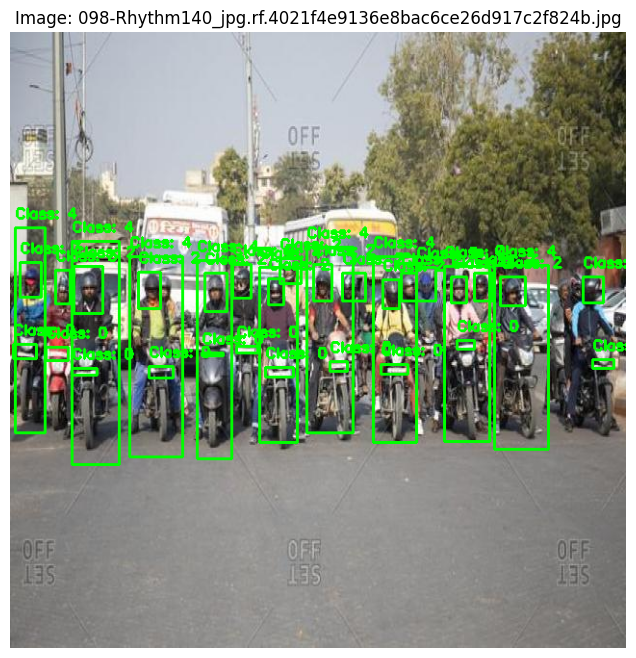

In [54]:
# Assuming very_small_boxes list is available from the previous cell (Yi8n_2yFfsOm)
# Assuming display_random_images_with_bboxes function is defined in a previous cell (JSMK7GW1mtZ8)

if very_small_boxes:
    # Get the filename of the first image with a very small box
    sample_image_filename = very_small_boxes[0]['image_filename']

    # Define directories (assuming they are already defined correctly in previous cells)
    image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images'
    annotation_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels'

    print(f"--- Displaying a sample image with very small boxes: {sample_image_filename} ---")

    # display_random_images_with_bboxes expects a list of filenames, so we put the single filename in a list
    display_random_images_with_bboxes([sample_image_filename], image_directory, annotation_directory, num_samples=1)
else:
    print("No very small boxes were found, so no sample image can be displayed.")

## Define augmentation pipeline

### Subtask:
Define a sequence of augmentation transformations to apply to the images and bounding boxes.

**Reasoning**:
Define an augmentation pipeline using albumentations with transformations suitable for object detection, including handling bounding boxes in YOLO format.

In [65]:
import albumentations as A
import cv2 # Import cv2 for BORDER_CONSTANT

# Define a list of class labels. This is a placeholder and should be replaced
# with the actual list of class names used in your dataset.
# Example: ['helmet', 'no_helmet', 'person', 'bike', 'car']
class_labels = [0, 1, 2, 3, 4] # Assuming class IDs 0-4 are used

# Define the augmentation pipeline based on user requirements
augmentation_pipeline = A.Compose([
    # Image resizing and multi-scale augmentation (zoom, resize jitter, overlapping crops)
    # RandomSizedBBoxSafeCrop handles cropping and resizing, simulating zoom/resize jitter
    A.RandomSizedBBoxSafeCrop(
        min_max_height=(480, 800), # Example range for random crop height
        width=640, # Resize to a common training size (adjust as needed)
        height=640, # Resize to a common training size (adjust as needed)
        p=0.7 # Increased probability
    ),

    # Horizontal flip
    A.HorizontalFlip(p=0.5),

    # Rotation
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT), # Slightly reduced rotation limit

    # Color normalization (HSV jitter)
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.7), # Increased jitter and probability

    # Hierarchical contrast (CLAHE) and some edge/sharpness related
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.3),
    A.Emboss(alpha=(0.1, 0.3), strength=(0.5, 1.0), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Additional contrast adjustment

    # Geometric transformations
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5), # Small shifts and scales

    # Adding some noise and blur for robustness
    A.GaussNoise(p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),


], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

print("Augmentation pipeline defined successfully with requested techniques.")

Augmentation pipeline defined successfully with requested techniques.


/tmp/ipython-input-774444831.py:13: UserWarning: Argument(s) 'min_max_height' are not valid for transform RandomSizedBBoxSafeCrop
  A.RandomSizedBBoxSafeCrop(
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### Define Augmentation Pipeline

This code block defines the sequence of image and bounding box transformations that will be applied for data augmentation using the `albumentations` library.

### Apply Augmentation to Dataset

This code block iterates through the suitable images, applies the defined augmentation pipeline to generate augmented versions, and saves the augmented images and their updated annotation files to a new directory in Google Drive.

### Plan Step 4: Apply Augmentation to Dataset

Iterate through your dataset, apply the augmentation function to each image and its annotations, and save the augmented data (images and updated annotation files).

In [61]:
import os
import cv2
import numpy as np

# Assuming apply_augmentation function, augmentation_pipeline, class_labels,
# annotations_by_image, and images_for_training are defined in previous cells.

# Define input and output directories
image_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/images'
annotation_directory = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive/train/labels'
output_base_dir = '/content/drive/My Drive/capstone_helmet_detection/augmented_data' # Define a new directory for augmented data

# Create output directories if they don't exist
output_images_dir = os.path.join(output_base_dir, 'images')
output_labels_dir = os.path.join(output_base_dir, 'labels')
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Number of augmented samples to generate per original image
num_augmentations_per_image = 3 # You can adjust this number

print(f"Starting data augmentation. Augmented data will be saved to: {output_base_dir}")

augmented_image_count = 0
augmented_annotation_count = 0

# Iterate through the list of images suitable for training
for image_filename in images_for_training: # Use the list of suitable images
    image_path = os.path.join(image_directory, image_filename)
    annotation_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
    annotation_path = os.path.join(annotation_directory, annotation_filename)

    # Check if annotation file exists
    if not os.path.exists(annotation_path):
        print(f"Skipping image {image_filename}: Annotation file not found.")
        continue

    # Load the original image using PIL (as cv2.imread had issues earlier)
    try:
        pil_image = Image.open(image_path)
        original_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"Skipping image {image_filename} due to loading error: {e}")
        continue

    # Load original annotations for the image
    original_annotations = []
    try:
        with open(annotation_path, 'r') as f:
            for line in f:
                try:
                    class_id, center_x, center_y, bbox_width, bbox_height = map(float, line.split())
                    original_annotations.append([int(class_id), center_x, center_y, bbox_width, bbox_height])
                except ValueError:
                    print(f"Skipping malformed annotation line in {annotation_filename}: {line.strip()}")
    except Exception as e:
        print(f"Skipping image {image_filename}: Could not read annotation file: {e}")
        continue


    # Apply augmentation multiple times
    for i in range(num_augmentations_per_image):
        try:
            augmented_image, augmented_annotations = apply_augmentation(
                original_image.copy(), # Pass a copy to avoid modifying the original image
                original_annotations.copy(), # Pass a copy of annotations
                class_labels
            )

            # Generate unique filename for the augmented image and annotation
            base_filename = os.path.splitext(image_filename)[0]
            augmented_image_filename = f"{base_filename}_aug_{i}.jpg" # Example naming convention
            augmented_annotation_filename = f"{base_filename}_aug_{i}.txt"

            output_image_path = os.path.join(output_images_dir, augmented_image_filename)
            output_annotation_path = os.path.join(output_labels_dir, augmented_annotation_filename)

            # Save the augmented image
            cv2.imwrite(output_image_path, augmented_image)
            augmented_image_count += 1

            # Save the augmented annotations
            with open(output_annotation_path, 'w') as f:
                for annot in augmented_annotations:
                    # Write in YOLO format: class_id center_x center_y width height (normalized)
                    # Ensure data types are correct (float for coords/size, int for class_id)
                    f.write(f"{int(annot[0])} {annot[1]:.6f} {annot[2]:.6f} {annot[3]:.6f} {annot[4]:.6f}\n")
                    augmented_annotation_count += 1

        except Exception as e:
            print(f"Error augmenting image {image_filename} iteration {i}: {e}")
            continue

print("-" * 50)
print(f"Augmentation process finished.")
print(f"Generated {augmented_image_count} augmented images.")
print(f"Generated {augmented_annotation_count} augmented bounding box annotations.")

Starting data augmentation. Augmented data will be saved to: /content/drive/My Drive/capstone_helmet_detection/augmented_data
Error augmenting image 098-Rhythm179_jpg.rf.b1b6924d257a2be718dcaae4222ef1ce.jpg iteration 0: The lengths of bboxes and class_labels do not match. Got 3 and 5 respectively.
Error augmenting image 098-Rhythm179_jpg.rf.b1b6924d257a2be718dcaae4222ef1ce.jpg iteration 1: The lengths of bboxes and class_labels do not match. Got 3 and 5 respectively.
Error augmenting image 098-Rhythm179_jpg.rf.b1b6924d257a2be718dcaae4222ef1ce.jpg iteration 2: The lengths of bboxes and class_labels do not match. Got 3 and 5 respectively.
Error augmenting image 036_37_jpg.rf.478a3caadf3c1426d879f57980270889.jpg iteration 0: The lengths of bboxes and class_labels do not match. Got 10 and 5 respectively.
Error augmenting image 036_37_jpg.rf.478a3caadf3c1426d879f57980270889.jpg iteration 1: The lengths of bboxes and class_labels do not match. Got 10 and 5 respectively.
Error augmenting imag

## Prepare data for yolov8 training

### Subtask:
Organize the original and augmented data into the required directory structure for YOLOv8 training (e.g., `train/images`, `train/labels`, `val/images`, `val/labels`). Update the `data.yaml` file to reflect the paths and class names.

**Reasoning**:
Create the directory structure for YOLOv8 training, split the original data into training and validation sets, and combine the training set with augmented data.

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths to original data and augmented data
original_data_dir = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive/archive' # Base directory of your original unzipped data
augmented_data_dir = '/content/drive/My Drive/capstone_helmet_detection/augmented_data' # Base directory of your augmented data

original_images_dir = os.path.join(original_data_dir, 'train', 'images')
original_labels_dir = os.path.join(original_data_dir, 'train', 'labels')
augmented_images_dir = os.path.join(augmented_data_dir, 'images')
augmented_labels_dir = os.path.join(augmented_data_dir, 'labels')


# Define the base directory for the new YOLOv8 format dataset
yolov8_data_base_dir = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset'

# Define the directories for YOLOv8 training structure
train_img_dir = os.path.join(yolov8_data_base_dir, 'train', 'images')
train_label_dir = os.path.join(yolov8_data_base_dir, 'train', 'labels')
val_img_dir = os.path.join(yolov8_data_base_dir, 'val', 'images')
val_label_dir = os.path.join(yolov8_data_base_dir, 'val', 'labels')
# Test set is optional, we will just use train and val for now
# test_img_dir = os.path.join(yolov8_data_base_dir, 'test', 'images')
# test_label_dir = os.path.join(yolov8_data_base_dir, 'test', 'labels')

# Create the new directories
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)
# os.makedirs(test_img_dir, exist_ok=True)
# os.makedirs(test_label_dir, exist_ok=True)

print("Created YOLOv8 dataset directory structure.")

# Get list of original image filenames (assuming images and labels have same base name)
original_image_files = [f for f in os.listdir(original_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
original_label_files = [f.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt') for f in original_image_files] # Get corresponding label filenames

# Split original data into training and validation sets
# We will use a portion of the original data for validation
train_files, val_files = train_test_split(original_image_files, test_size=0.2, random_state=42) # 80% train, 20% val

print(f"Original images: {len(original_image_files)}")
print(f"Original train images for split: {len(train_files)}")
print(f"Original val images for split: {len(val_files)}")


# Copy original training data to the new train directories
print("\nCopying original training data...")
for filename in train_files:
    base_filename = os.path.splitext(filename)[0]
    img_src = os.path.join(original_images_dir, filename)
    label_src = os.path.join(original_labels_dir, base_filename + '.txt')
    img_dst = os.path.join(train_img_dir, filename)
    label_dst = os.path.join(train_label_dir, base_filename + '.txt')
    if os.path.exists(img_src):
        shutil.copy(img_src, img_dst)
    if os.path.exists(label_src):
        shutil.copy(label_src, label_dst)

print("Finished copying original training data.")

# Copy original validation data to the new val directories
print("\nCopying original validation data...")
for filename in val_files:
    base_filename = os.path.splitext(filename)[0]
    img_src = os.path.join(original_images_dir, filename)
    label_src = os.path.join(original_labels_dir, base_filename + '.txt')
    img_dst = os.path.join(val_img_dir, filename)
    label_dst = os.path.join(val_label_dir, base_filename + '.txt')
    if os.path.exists(img_src):
        shutil.copy(img_src, img_dst)
    if os.path.exists(label_src):
        shutil.copy(label_src, label_dst)
print("Finished copying original validation data.")

# Copy augmented data to the new train directories
print("\nCopying augmented data...")
augmented_image_files = [f for f in os.listdir(augmented_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for filename in augmented_image_files:
    base_filename = os.path.splitext(filename)[0]
    img_src = os.path.join(augmented_images_dir, filename)
    label_src = os.path.join(augmented_labels_dir, base_filename + '.txt')
    img_dst = os.path.join(train_img_dir, filename)
    label_dst = os.path.join(train_label_dir, base_filename + '.txt')
    if os.path.exists(img_src):
        shutil.copy(img_src, img_dst)
    if os.path.exists(label_src):
        shutil.copy(label_src, label_dst)
print("Finished copying augmented data.")

print("\nData preparation for YOLOv8 training complete.")

Created YOLOv8 dataset directory structure.
Original images: 800
Original train images for split: 640
Original val images for split: 160

Copying original training data...
Finished copying original training data.

Copying original validation data...
Finished copying original validation data.

Copying augmented data...
Finished copying augmented data.

Data preparation for YOLOv8 training complete.


### Plan Step 3: Implement Augmentation Function

Create a function that takes an image and its annotations, applies the augmentation pipeline, and returns the augmented image and annotations.

# Helmet Violation Detection from Indian CCTV Video

**Problem statement:**
Detect and flag two-wheeler helmet violations (helmetless riding) from traffic camera frames in Indian cities in real-time.

**Description:**
Create a computer vision system using YOLOv8 and object tracking to detect two-wheeler riders and classify helmet usage. Optionally perform license plate OCR for enforcement.

---

## 1. Setup and Data Loading

This section covers mounting Google Drive to access the dataset and extracting the data from the zip file.

### Mount Google Drive

Mount your Google Drive to access files stored there persistently. This is necessary because files uploaded directly to Colab's temporary storage (`/content/sample_data/`) are deleted when the runtime ends.

In [ ]:
from google.colab import drive

# Mount Google Drive at /content/drive
# This will prompt you to authorize Colab to access your Google Drive files.
# If you encounter issues with 'My Drive' containing spaces, mounting to '/content/drive' is recommended.
drive.mount('/content/drive')

### Extract Dataset from Zip File

Extract the contents of the dataset zip file stored in your Google Drive to a designated folder within your Drive. This ensures the unzipped data is also persistent.

In [ ]:
import zipfile
import os

# Define the path to your zip file in Google Drive
# Ensure this path correctly points to where you uploaded archive2.zip in your Drive.
# Example: If archive2.zip is in a folder named 'capstone_helmet_detection' in your Drive:
zip_file_path = '/content/drive/My Drive/capstone_helmet_detection/archive2.zip'

# Define the directory within Google Drive where the contents will be extracted
# This folder will be created if it doesn't exist and ensures persistence.
extraction_path = '/content/drive/My Drive/capstone_helmet_detection/unzipped_archive'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified extraction_path
        zip_ref.extractall(extraction_path)
    print(f"Successfully extracted {zip_file_path} to {extraction_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
    print("Please ensure the zip file is in the correct location in your Google Drive.")
except zipfile.BadZipFile:
    print(f"Error: The file at {zip_file_path} is not a valid zip file.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Define the base directory for the extracted data.
# Based on previous analysis, the structure seems to be unzipped_archive/archive/train and unzipped_archive/archive/val
extracted_data_base_dir = os.path.join(extraction_path, 'archive')

## 2. Data Exploration and Analysis

This section explores the dataset's characteristics, including file counts, image sizes, class distribution, and bounding box quality.

### Count Image and Annotation Files

Count the number of image and annotation files in the extracted dataset directories to get an overview of the dataset size.

In [ ]:
import os

# Define the directories for images and labels based on the extracted data path
# Adjust extracted_data_base_dir if your data structure is different (e.g., if 'archive' subfolder doesn't exist)
image_directory = os.path.join(extracted_data_base_dir, 'train', 'images')
annotations_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')

# Check if directories exist before listing files
if not os.path.exists(image_directory):
    print(f"Error: Image directory not found at {image_directory}")
    all_image_filenames = []
else:
    # Get a list of all image files in the image directory
    all_image_filenames = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not os.path.exists(annotations_dir):
    print(f"Error: Annotations directory not found at {annotations_dir}")
    annotation_files = []
else:
    # Get a list of all annotation files in the annotations directory
    annotation_files = [f for f in os.listdir(annotations_dir) if f.lower().endswith('.txt')]


print(f"Total image files found in {image_directory}: {len(all_image_filenames)}")
print(f"Total annotation files found in {annotations_dir}: {len(annotation_files)}")

# Note: all_image_filenames is stored for later use

### Analyze Image Size Distribution

Analyze and visualize the distribution of image sizes in the dataset. This helps understand if images are of a consistent size or vary, which can impact model training.

In [ ]:
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define the directory containing the images (uses image_directory from previous cell)
# image_directory = ...

# Get a list of all image file paths
# We will only process a reasonable number of images for size analysis if the dataset is very large
image_paths_for_size_analysis = [os.path.join(image_directory, f) for f in all_image_filenames]


sizes = []
# Iterate through image paths and get their sizes
for img_path in image_paths_for_size_analysis:
    try:
        with Image.open(img_path) as img:
            sizes.append(img.size)
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")


# Create a DataFrame from the collected sizes
df_sizes = pd.DataFrame(sizes, columns=["Width", "Height"])

# Print descriptive statistics of the image sizes
print("Image Size Distribution Statistics:")
print(df_sizes.describe())

# Plot the image size distribution as a scatter plot
plt.figure(figsize=(8, 8))
df_sizes.plot(kind="scatter", x="Width", y="Height", alpha=0.5, figsize=(6,6))
plt.title("Image Size Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.show()

# Assuming all images are 640x640 based on the analysis output
# Store these dimensions if needed later
image_width = 640
image_height = 640

### Analyze Class Distribution

Analyze the distribution of object classes within the dataset's annotations. This helps identify class imbalance, which might require specific handling during model training.

In [ ]:
import os

# Define the directory containing the annotation files (uses annotations_dir from previous cell)
# annotations_dir = ...

# Dictionary to store class counts
class_counts = {}
all_annotations_list = [] # List to store all annotations for co-occurrence analysis

# Iterate through each annotation file
if os.path.exists(annotations_dir):
    for filename in os.listdir(annotations_dir):
        # Process only .txt files (assuming YOLO format annotations)
        if filename.lower().endswith('.txt'):
            annotation_path = os.path.join(annotations_dir, filename)
            try:
                # Read each line in the annotation file
                with open(annotation_path, 'r') as f:
                    for line in f:
                        try:
                            # The first value in each line is the class_id (YOLO format)
                            parts = line.split()
                            if len(parts) >= 5:
                                class_id = int(parts[0])
                                # Increment the count for this class_id
                                if class_id in class_counts:
                                    class_counts[class_id] += 1
                                else:
                                    class_counts[class_id] = 1

                                # Also store annotation details for co-occurrence analysis
                                all_annotations_list.append({
                                    'image_filename': filename.replace('.txt', '.jpg'), # Assuming corresponding image is .jpg
                                    'class_id': int(parts[0]),
                                    'center_x': float(parts[1]),
                                    'center_y': float(parts[2]),
                                    'bbox_width': float(parts[3]),
                                    'bbox_height': float(parts[4])
                                })
                            else:
                                print(f"Skipping malformed line (incomplete) in {filename}: {line.strip()}")
                        except (ValueError, IndexError):
                            # Handle lines that might not be in the expected format
                            print(f"Skipping malformed line (ValueError/IndexError) in {filename}: {line.strip()}")
            except Exception as e:
                print(f"Could not read annotation file {filename}: {e}")
else:
    print(f"Error: Annotations directory not found at {annotations_dir}")


# Print the class distribution
print("Class distribution across all annotations:")
# Sort by class ID for consistent output
for class_id in sorted(class_counts.keys()):
    print(f"Class {class_id}: {class_counts[class_id]}")

# Note: all_annotations_list is stored for later use (co-occurrence analysis)

### Define Class Names

Based on manual inspection or dataset documentation, define the mapping of class IDs to human-readable names. This is crucial for interpreting results and configuring YOLOv8.

In [ ]:
# Define the class names based on the mapping you provided:
# 0 → Vehicle number
# 1 → Rider without helmet
# 2 → Rider with valid helmet
# 3 → Rider with invalid helmet
# 4 → Motorbike with a person

class_names = ['Vehicle number', 'Rider without helmet', 'Rider with valid helmet', 'Rider with invalid helmet', 'Motorbike with a person']
num_classes = len(class_names) # Number of classes

print("Defined class names:")
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")

# Note: class_names and num_classes are stored for later use (data.yaml, visualization)

### Visualize Sample Images with Bounding Boxes

Define a function to display random images with their corresponding bounding boxes and class labels drawn on them. This is useful for visually inspecting annotations and understanding the data.

In [ ]:
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display random images with bounding boxes from a given list of filenames
# Assumes class_names list is available in the environment
def display_random_images_with_bboxes(image_filenames, image_directory, annotation_directory, num_samples=5):
    """
    Displays random images with bounding boxes from a list of filenames.

    Args:
        image_filenames (list): A list of image filenames to choose from.
        image_directory (str): The directory where the images are located.
        annotation_directory (str): The directory where the annotation files are located.
        num_samples (int): The number of random images to display.
    """
    if not image_filenames:
        print("No image files provided in the list.")
        return

    # Select random image files from the provided list
    num_samples = min(num_samples, len(image_filenames)) # Ensure we don't ask for more samples than available
    random_image_filenames = random.sample(image_filenames, num_samples)

    for image_filename in random_image_filenames:
        image_path = os.path.join(image_directory, image_filename)
        # Assuming annotation filename has the same base name as the image with a .txt extension
        annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
        annotation_path = os.path.join(annotation_directory, annotation_filename)

        # Load the image using PIL and convert to OpenCV format
        # Using PIL as cv2.imread sometimes had issues with mounted Drive paths
        try:
            pil_image = Image.open(image_path)
            # Convert PIL image to NumPy array (BGR format for OpenCV)
            # Ensure image is not None and convert to BGR
            if pil_image is not None:
                 image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
                 h, w, _ = image.shape
            else:
                 print(f"Could not open image {image_path}")
                 image = None
        except Exception as e:
            print(f"Could not load or process image {image_path}: {e}")
            image = None # Set image to None if loading fails

        # Read the annotation file and draw bounding boxes
        if image is not None and os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                for line in f:
                    try:
                        # YOLO format: class_id center_x center_y width height (normalized)
                        parts = line.split()
                        if len(parts) < 5:
                             print(f"Skipping incomplete annotation line in {annotation_filename}: {line.strip()}")
                             continue
                        class_id = int(parts[0])
                        center_x, center_y, bbox_width, bbox_height = map(float, parts[1:5])

                        # Convert normalized coordinates to pixel coordinates
                        x_center = int(center_x * w)
                        y_center = int(center_y * h)

                        box_w = int(bbox_width * w)
                        box_h = int(bbox_height * h)

                        # Calculate top-left corner coordinates
                        x_min = int(x_center - box_w / 2)
                        y_min = int(y_center - box_h / 2)
                        x_max = int(x_center + box_w / 2)
                        y_max = int(y_center + box_h / 2)

                        # Draw bounding box (Green color, thickness 2)
                        # You can define colors per class if needed
                        color = (0, 255, 0) # Green

                        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

                        # Put class label (using defined class_names if available)
                        label = f"Class: {class_id}"
                        if 'class_names' in globals() and class_id < len(class_names):
                            label = class_names[class_id]

                        # Position the text slightly above the top-left corner
                        text_x = x_min
                        text_y = y_min - 10 # 10 pixels above the box

                        # Ensure text does not go out of image bounds
                        if text_y < 0:
                           text_y = y_min + 15 # Position below if needed


                        cv2.putText(image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA) # Increased font size slightly


                    except Exception as e:
                        print(f"Could not process annotation line in {annotation_filename}: {line.strip()} - {e}")


            # Display the image (using matplotlib)
            # Convert BGR image to RGB for matplotlib display
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10)) # Adjust figure size for better viewing
            plt.imshow(image_rgb)
            plt.title(f"Image: {image_filename}")
            plt.axis('off') # Hide axes ticks and labels
            plt.show()


        elif image is None:
            print(f"Skipping {image_filename} due to loading error.")
        else:
            print(f"Annotation file not found for {image_filename} at {annotation_path}")

# This cell now defines the function. Call this function from another cell to display images.

### Analyze Class Co-occurrence and Display Samples

Analyze the co-occurrence of specific classes in the dataset to identify images suitable for training based on defined criteria. Then, display sample images from both suitable and unsuitable categories.

In [ ]:
# Assuming all_annotations_list is available from loading annotations
# Assuming image_directory and annotations_dir are defined

# Group annotations by image filename
annotations_by_image = {}
for annotation in all_annotations_list:
    image_filename = annotation['image_filename']
    if image_filename not in annotations_by_image:
        annotations_by_image[image_filename] = []
    annotations_by_image[image_filename].append(annotation)


# Analyze class co-occurrence based on your criteria:
# Images must contain Class 4 (Motorbike with a person), Class 0 (Vehicle number),
# AND at least one of the rider classes (1: Rider without helmet, 2: Rider with valid helmet, 3: Rider with invalid helmet)
images_for_training = []
required_rider_classes = {1, 2, 3} # Set of class IDs for riders

for image_filename, annotations in annotations_by_image.items():
    # Get the set of unique class IDs present in the current image's annotations
    present_classes = {annotation['class_id'] for annotation in annotations}

    # Check for the required classes
    has_class_4 = 4 in present_classes
    has_class_0 = 0 in present_classes
    # Check if any of the rider classes are present
    has_rider_class = any(rider_class in present_classes for rider_class in required_rider_classes)

    # If all criteria are met, add the image filename to the list of suitable images
    if has_class_4 and has_class_0 and has_rider_class:
        images_for_training.append(image_filename)

print(f"Total images analyzed for co-occurrence: {len(annotations_by_image)}")
print(f"Number of images suitable for training based on co-occurrence criteria: {len(images_for_training)}")

# Identify images not suitable for training (all images minus suitable ones)
all_image_filenames_set = set(annotations_by_image.keys())
suitable_image_filenames_set = set(images_for_training)
not_suitable_image_filenames = list(all_image_filenames_set - suitable_image_filenames_set)
suitable_image_filenames_list = list(suitable_image_filenames_set) # Convert set back to list for sampling


# Display sample images from both categories
print("\n--- Suitable Images for Training (Sample) ---")
# Display 3 random samples from the suitable images list
display_random_images_with_bboxes(suitable_image_filenames_list, image_directory, annotations_dir, num_samples=3)

print("\n--- Not Suitable Images for Training (Sample) ---")
# Display 3 random samples from the not suitable images list
display_random_images_with_bboxes(not_suitable_image_filenames, image_directory, annotations_dir, num_samples=3)

### Perform Annotation Quality Check

Analyze the quality of bounding box annotations by checking for very small boxes and boxes that extend outside the image boundaries.

In [ ]:
import os

# Assuming annotations_by_image dictionary is available from grouping annotations
# Assuming image_directory is defined
# Assuming image_width and image_height are defined (e.g., 640x640)

print("--- Annotation Quality Check ---")

very_small_boxes = []
boxes_outside_image = []

# Define a threshold for "very small" boxes in pixels (e.g., less than 10x10 pixels)
# Adjust this threshold based on your specific requirements and dataset
small_box_threshold_width = 10  # pixels
small_box_threshold_height = 10 # pixels

# Assuming all images have a consistent size based on previous analysis (e.g., 640x640)
# If image sizes vary, you would need to load each image to get its dimensions here.
# For this dataset, analysis in Step 2.2 confirmed all images are 640x640.
# image_width = 640
# image_height = 640


# Iterate through annotations grouped by image
for image_filename, annotations in annotations_by_image.items():
    for annotation in annotations:
        class_id = annotation['class_id']
        center_x_norm = annotation['center_x']
        center_y_norm = annotation['center_y']
        bbox_width_norm = annotation['bbox_width']
        bbox_height_norm = annotation['bbox_height']

        # Convert normalized coordinates to pixel coordinates
        # Ensure calculations handle potential floating point inaccuracies
        x_center = int(round(center_x_norm * image_width))
        y_center = int(round(center_y_norm * image_height))
        box_w = int(round(bbox_width_norm * image_width))
        box_h = int(round(bbox_height_norm * image_height))

        # Calculate top-left and bottom-right corner coordinates in pixels
        x_min = int(x_center - box_w / 2)
        y_min = int(y_center - box_h / 2)
        x_max = int(x_center + box_w / 2)
        y_max = int(y_center + box_h / 2)

        # Check for very small boxes based on the defined threshold
        if box_w < small_box_threshold_width or box_h < small_box_threshold_height:
            very_small_boxes.append({
                'image_filename': image_filename,
                'class_id': class_id,
                'width_pixels': box_w,
                'height_pixels': box_h,
                'bbox_norm': (center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm)
            })

        # Check for boxes outside image boundaries
        # Check if any corner or edge is outside the [0, image_width) or [0, image_height) range
        if x_min < -1 or y_min < -1 or x_max > image_width + 1 or y_max > image_height + 1: # Add a small buffer for floating point
             boxes_outside_image.append({
                'image_filename': image_filename,
                'class_id': class_id,
                'x_min': x_min,
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max,
                'bbox_norm': (center_x_norm, center_y_norm, bbox_width_norm, bbox_height_norm)
            })

# Report findings on very small boxes
print(f"Number of very small boxes found (threshold: {small_box_threshold_width}x{small_box_threshold_height} pixels): {len(very_small_boxes)}")
if very_small_boxes:
    print("Examples of very small boxes:")
    # Print first 5 examples
    for i, box_info in enumerate(very_small_boxes[:5]):
        print(f"  Image: {box_info['image_filename']}, Class: {box_info['class_id']}, Size: {box_info['width_pixels']}x{box_info['height_pixels']}")

# Report findings on boxes outside image boundaries
print(f"\nNumber of boxes outside image boundaries found: {len(boxes_outside_image)}")
if boxes_outside_image:
    print("Examples of boxes outside image boundaries:")
    # Print first 5 examples
    for i, box_info in enumerate(boxes_outside_image[:5]):
         print(f"  Image: {box_info['image_filename']}, Class: {box_info['class_id']}, Bbox Pixels: ({box_info['x_min']}, {box_info['y_min']}, {box_info['x_max']}, {box_info['y_max']})")

# Note: This check assumes all images are 640x640 as found in previous analysis.
# If image sizes vary, you would need to load each image to get its dimensions.

### Display Sample Image with Very Small Boxes

Display a sample image that contains one or more very small bounding boxes to visually assess the issue.

In [ ]:
# Assuming very_small_boxes list is available from the previous quality check cell
# Assuming display_random_images_with_bboxes function is defined

if very_small_boxes:
    # Get the filename of the first image identified as having a very small box
    sample_image_filename = very_small_boxes[0]['image_filename']

    # Define directories (assuming they are already defined correctly)
    # image_directory = os.path.join(extracted_data_base_dir, 'train', 'images')
    # annotations_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')


    print(f"--- Displaying a sample image with very small boxes: {sample_image_filename} ---")

    # Use the display function to show this specific image.
    # The function will draw all bboxes for this image, including the small ones.
    display_random_images_with_bboxes([sample_image_filename], image_directory, annotations_dir, num_samples=1)
else:
    print("No very small boxes were found, so no sample image can be displayed.")

---

## 3. Data Augmentation

This section focuses on applying data augmentation techniques to the dataset to increase its size and variability, which can help improve model performance, especially for detecting small objects and addressing class imbalance.

### Install Augmentation Library

Install a suitable data augmentation library for object detection (e.g., Albumentations) and its dependencies.

In [ ]:
# Install Albumentations and opencv-python-headless
# opencv-python-headless is used by Albumentations for image processing
%pip install albumentations opencv-python-headless

# Note: You might need to restart the runtime after installation if prompted.

### Define Augmentation Pipeline

Define a sequence of image and bounding box transformations to apply for data augmentation using the `albumentations` library.

In [ ]:
import albumentations as A
import cv2 # Import cv2 as it's needed for some Albumentations border modes

# Define a list of class IDs. This is used by Albumentations to correctly transform bounding box labels.
# Assumes class_names list is already defined, getting the number of classes from it.
class_ids_list = list(range(num_classes)) # [0, 1, 2, 3, 4]

# Define the augmentation pipeline based on your requested techniques
augmentation_pipeline = A.Compose([
    # Image resizing and multi-scale augmentation (zoom, resize jitter, overlapping crops)
    # RandomSizedBBoxSafeCrop crops a random part of the image and resizes it.
    # This helps with scale variation and makes small objects appear larger in the crop.
    # Using target size 640x640 to match expected model input size.
    A.RandomSizedBBoxSafeCrop(
        min_max_height=(480, 800), # Example range for random crop height before resizing
        width=640, # Target output width after cropping and resizing
        height=640, # Target output height after cropping and resizing
        p=0.7 # Probability of applying this transform
    ),

    # Horizontal flip: Flips the image and bounding boxes horizontally. Useful for many datasets.
    A.HorizontalFlip(p=0.5),

    # Rotation: Rotates the image and bounding boxes by a limited angle.
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Rotate by up to 10 degrees, fill borders with black


    # Color normalization (HSV jitter), brightness, contrast, saturation adjustments
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.7), # Adjust brightness, contrast, saturation, hue

    # Hierarchical contrast (CLAHE) and sharpness/emboss effects for edge-based variations
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5), # Apply CLAHE for local contrast enhancement
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.3), # Apply sharpening
    A.Emboss(alpha=(0.1, 0.3), strength=(0.5, 1.0), p=0.3), # Apply emboss effect
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Additional random brightness/contrast

    # Geometric transformations: Small shifts and scales
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0), # Small shifts and scales, no rotation here as it's done above

    # Adding some noise and blur for robustness to image quality variations
    A.GaussNoise(p=0.3), # Add Gaussian noise
    A.GaussianBlur(blur_limit=(3, 7), p=0.3), # Apply Gaussian blur


], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])) # Specify YOLO format for bounding boxes and the field containing labels

print("Augmentation pipeline defined successfully with requested techniques.")

### Implement Augmentation Function

Create a Python function that takes an image and its annotations, applies the defined augmentation pipeline, and returns the augmented data.

In [ ]:
import numpy as np
import cv2
import albumentations as A # Ensure A is imported

# Assuming augmentation_pipeline is defined in the previous cell

def apply_augmentation(image, annotations):
    """
    Applies the defined augmentation pipeline to an image and its bounding boxes.

    Args:
        image (np.ndarray): The input image as a NumPy array (H, W, C), expected in BGR format.
        annotations (list): A list of bounding box annotations in YOLO format.
                           Each annotation is a list or tuple: [class_id, center_x, center_y, width, height].

    Returns:
        tuple: A tuple containing:
               - augmented_image (np.ndarray): The augmented image (in BGR format).
               - augmented_annotations (list): A list of augmented bounding box annotations in YOLO format.
                                               Each annotation is a list: [class_id, center_x, center_y, width, height].
               Returns (None, None) if augmentation fails.
    """
    # Albumentations expects bounding boxes in a specific format for 'yolo':
    # list of tuples: (x_center, y_center, width, height)
    # And coordinates should be normalized (0 to 1)
    # The class_id is passed separately using the 'class_labels' parameter.

    bboxes = []
    bbox_class_labels = [] # List to store class labels corresponding to each bbox

    for annot in annotations:
        # Ensure annotation is in the correct format and contains enough values
        if len(annot) >= 5:
            # Extract class_id and normalized bbox coordinates
            class_id = int(annot[0])
            center_x, center_y, bbox_width, bbox_height = annot[1:5]

            # Append bbox in the format expected by Albumentations (x_c, y_c, w, h)
            bboxes.append([center_x, center_y, bbox_width, bbox_height])
            # Store the class_id for this bbox
            bbox_class_labels.append(class_id)
        else:
            print(f"Warning: Skipping malformed annotation: {annot}")

    # Apply the augmentation pipeline
    # The image should be in RGB format for Albumentations
    try:
        # Ensure image is not None before converting color
        if image is None:
            print("Error: Input image is None.")
            return None, None

        augmented = augmentation_pipeline(
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB), # Convert BGR input to RGB for Albumentations
            bboxes=bboxes,
            class_labels=bbox_class_labels # Pass the list of class labels for each bbox
        )
    except Exception as e:
        print(f"Error during augmentation pipeline application: {e}")
        # Return None, None if augmentation fails for this image
        return None, None


    # Extract augmented image and bounding boxes
    augmented_image = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR) # Convert augmented RGB image back to BGR
    augmented_bboxes_alb = augmented['bboxes']
    augmented_class_labels_output = augmented['class_labels']


    # Convert augmented bounding boxes back to YOLO format [class_id, center_x, center_y, width, height]
    augmented_annotations = []
    for bbox_alb, class_lbl in zip(augmented_bboxes_alb, augmented_class_labels_output):
         # Ensure bbox_alb has 4 elements (x_c, y_c, w, h)
        if len(bbox_alb) >= 4:
            # Albumentations returns [x_c, y_c, w, h] for yolo format
            augmented_annotations.append([int(class_lbl), bbox_alb[0], bbox_alb[1], bbox_alb[2], bbox_alb[3]])
        else:
            print(f"Warning: Skipping malformed augmented bounding box: {bbox_alb} with class label {class_lbl}")


    return augmented_image, augmented_annotations

print("Augmentation function defined successfully.")

### Apply Augmentation to Dataset

Iterate through the images suitable for training, apply the augmentation function multiple times to each, and save the augmented images and their updated annotation files.

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image # Import PIL for image loading
# Assuming apply_augmentation function is defined
# Assuming images_for_training list is available from co-occurrence analysis
# Assuming image_directory and annotations_dir are defined (pointing to original data)


# Define the output base directory for augmented data within Google Drive
augmented_output_base_dir = '/content/drive/My Drive/capstone_helmet_detection/augmented_data'

# Define the output directories for augmented images and labels
augmented_images_dir = os.path.join(augmented_output_base_dir, 'images')
augmented_labels_dir = os.path.join(augmented_output_base_dir, 'labels')

# Create output directories if they don't exist
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

# Number of augmented samples to generate per original image
# Adjust this number based on how much you want to increase your dataset size
num_augmentations_per_image = 3

print(f"Starting data augmentation. Augmented data will be saved to: {augmented_output_base_dir}")

augmented_image_count = 0
augmented_annotation_count = 0

# Iterate through the list of images previously identified as suitable for training
# This ensures we only augment images that meet your co-occurrence criteria
for image_filename in images_for_training:
    original_image_path = os.path.join(image_directory, image_filename)
    # Assuming original annotation filename has the same base name as the image with a .txt extension
    original_annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
    original_annotation_path = os.path.join(annotations_dir, original_annotation_filename)

    # Check if annotation file exists for the original image
    if not os.path.exists(original_annotation_path):
        print(f"Skipping image {image_filename}: Original annotation file not found at {original_annotation_path}.")
        continue

    # Load the original image using PIL (as cv2.imread sometimes had issues)
    try:
        pil_image = Image.open(original_image_path)
        original_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR) # Convert PIL to OpenCV BGR format
    except Exception as e:
        print(f"Skipping image {image_filename} due to loading error from {original_image_path}: {e}")
        continue

    # Load original annotations for the image
    original_annotations = []
    try:
        with open(original_annotation_path, 'r') as f:
            for line in f:
                try:
                    # Parse YOLO format: class_id center_x center_y width height (normalized)
                    parts = line.split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        center_x, center_y, bbox_width, bbox_height = map(float, parts[1:5])
                        original_annotations.append([class_id, center_x, center_y, bbox_width, bbox_height])
                    else:
                         print(f"Skipping malformed annotation line in {original_annotation_filename}: {line.strip()}")
                except ValueError:
                    print(f"Skipping malformed annotation line (ValueError) in {original_annotation_filename}: {line.strip()}")
    except Exception as e:
        print(f"Skipping image {image_filename}: Could not read original annotation file from {original_annotation_path}: {e}")
        continue

    # Skip augmentation if no valid annotations were loaded for the image
    if not original_annotations:
        print(f"Skipping augmentation for {image_filename}: No valid annotations found.")
        continue


    # Apply augmentation multiple times to generate augmented samples
    for i in range(num_augmentations_per_image):
        try:
            # Apply the augmentation pipeline using the function
            augmented_image, augmented_annotations = apply_augmentation(
                original_image.copy(), # Pass a copy to avoid modifying the original image
                original_annotations.copy() # Pass a copy of annotations
                # class_labels is handled internally by apply_augmentation now
            )

            # Only process and save if augmentation was successful and returned data
            if augmented_image is not None and augmented_annotations is not None:

                # Generate unique filename for the augmented image and annotation
                base_filename = os.path.splitext(image_filename)[0]
                # Example naming: original_filename_aug_iteration.jpg/txt
                augmented_image_filename = f"{base_filename}_aug_{i}.jpg"
                augmented_annotation_filename = f"{base_filename}_aug_{i}.txt"

                output_image_path = os.path.join(augmented_images_dir, augmented_image_filename)
                output_annotation_path = os.path.join(augmented_labels_dir, augmented_annotation_filename)

                # Save the augmented image
                cv2.imwrite(output_image_path, augmented_image)
                augmented_image_count += 1

                # Save the augmented annotations in YOLO format
                with open(output_annotation_path, 'w') as f:
                    for annot in augmented_annotations:
                        # Write in YOLO format: class_id center_x center_y width height (normalized)
                        # Ensure data types and formatting are correct (float for coords/size with sufficient precision)
                        f.write(f"{int(annot[0])} {annot[1]:.6f} {annot[2]:.6f} {annot[3]:.6f} {annot[4]:.6f}\n")
                    augmented_annotation_count += len(augmented_annotations) # Count individual annotations

        except Exception as e:
            print(f"Error augmenting or saving image {image_filename} iteration {i}: {e}")
            # Continue to the next iteration or image even if one fails


print("-" * 50)
print(f"Data augmentation process finished.")
print(f"Generated {augmented_image_count} augmented images.")
print(f"Generated {augmented_annotation_count} augmented bounding box annotations.")

### Verify Augmented Data (Optional)

It's a good practice to visualize some of the augmented images with their new bounding boxes to ensure the augmentation pipeline is working as expected and bounding boxes are correctly transformed.

In [ ]:
import os
# Assuming display_random_images_with_bboxes function is defined
# Assuming augmented_images_dir and augmented_labels_dir are defined

print("--- Displaying Sample Augmented Images ---")

# Get a list of augmented image filenames
if os.path.exists(augmented_images_dir):
    augmented_image_filenames = [f for f in os.listdir(augmented_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
else:
    print(f"Augmented images directory not found at {augmented_images_dir}")
    augmented_image_filenames = []

# Display a sample of augmented images
if augmented_image_filenames:
    # Display 3 random samples from the augmented images
    display_random_images_with_bboxes(augmented_image_filenames, augmented_images_dir, augmented_labels_dir, num_samples=3)
else:
    print("No augmented images found to display.")

---

## 4. Data Preparation for YOLOv8 Training

This section prepares the dataset in the specific directory structure required by YOLOv8, combining original (for validation) and augmented (for training) data.

### Organize Data Directories and Split Dataset

Create the necessary directory structure for YOLOv8 (`train`, `val`) and copy the original dataset (splitting into train/validation) and the augmented dataset (for training) into these directories.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths to original data and augmented data based on previous steps
# extracted_data_base_dir should point to the root of your unzipped archive structure
# augmented_output_base_dir should point to where augmented data was saved

original_images_dir = os.path.join(extracted_data_base_dir, 'train', 'images')
original_labels_dir = os.path.join(extracted_data_base_dir, 'train', 'labels')
augmented_images_dir = os.path.join(augmented_output_base_dir, 'images')
augmented_labels_dir = os.path.join(augmented_output_base_dir, 'labels')


# Define the base directory for the new YOLOv8 format dataset structure
yolov8_data_base_dir = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset_prepared' # Using a new dir name to avoid overwriting previous attempts

# Define the directories for the YOLOv8 training structure
train_img_dir_yolo = os.path.join(yolov8_data_base_dir, 'train', 'images')
train_label_dir_yolo = os.path.join(yolov8_data_base_dir, 'train', 'labels')
val_img_dir_yolo = os.path.join(yolov8_data_base_dir, 'val', 'images')
val_label_dir_yolo = os.path.join(yolov8_data_base_dir, 'val', 'labels')
# Test set is optional for now, we will just use train and val

# Create the new YOLOv8 format directories
os.makedirs(train_img_dir_yolo, exist_ok=True)
os.makedirs(train_label_dir_yolo, exist_ok=True)
os.makedirs(val_img_dir_yolo, exist_ok=True)
os.makedirs(val_label_dir_yolo, exist_ok=True)

print("Created YOLOv8 dataset directory structure.")

# Get list of original image filenames
# Assuming images and labels have the same base name and are in the train folder of original data
if os.path.exists(original_images_dir):
    original_image_files = [f for f in os.listdir(original_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
else:
    print(f"Error: Original images directory not found at {original_images_dir}. Cannot split data.")
    original_image_files = []

# Split original data into training and validation sets (e.g., 80/20 split)
# We use the original data for the validation set to evaluate on unseen, non-augmented data.
# A portion of original data is also used in the training set before adding augmented data.
if original_image_files:
    train_files_orig, val_files_orig = train_test_split(original_image_files, test_size=0.2, random_state=42) # 80% train, 20% val
    print(f"Original images found: {len(original_image_files)}")
    print(f"Original images allocated for YOLOv8 train split: {len(train_files_orig)}")
    print(f"Original images allocated for YOLOv8 val split: {len(val_files_orig)}")

    # Copy original training data split to the new YOLOv8 train directories
    print("\nCopying original training data split...")
    for filename in train_files_orig:
        base_filename = os.path.splitext(filename)[0]
        img_src = os.path.join(original_images_dir, filename)
        label_src = os.path.join(original_labels_dir, base_filename + '.txt')
        img_dst = os.path.join(train_img_dir_yolo, filename)
        label_dst = os.path.join(train_label_dir_yolo, base_filename + '.txt')
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_src, label_dst)
        elif os.path.exists(img_src):
             print(f"Warning: Label file not found for original train image {filename}. Skipping copy.")
        else:
             print(f"Warning: Original train image {filename} not found. Skipping copy.")

    print("Finished copying original training data split.")

    # Copy original validation data split to the new YOLOv8 val directories
    print("\nCopying original validation data split...")
    for filename in val_files_orig:
        base_filename = os.path.splitext(filename)[0]
        img_src = os.path.join(original_images_dir, filename)
        label_src = os.path.join(original_labels_dir, base_filename + '.txt')
        img_dst = os.path.join(val_img_dir_yolo, filename)
        label_dst = os.path.join(val_label_dir_yolo, base_filename + '.txt')
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_src, label_dst)
        elif os.path.exists(img_src):
             print(f"Warning: Label file not found for original val image {filename}. Skipping copy.")
        else:
             print(f"Warning: Original val image {filename} not found. Skipping copy.")
    print("Finished copying original validation data split.")

else:
    print("No original images found. Skipping data splitting and copying original data.")


# Copy augmented data to the new YOLOv8 train directories
# Augmented data is typically only used for training
print("\nCopying augmented data to train directory...")
if os.path.exists(augmented_images_dir):
    augmented_image_files = [f for f in os.listdir(augmented_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Augmented images found: {len(augmented_image_files)}")
    for filename in augmented_image_files:
        base_filename = os.path.splitext(filename)[0]
        img_src = os.path.join(augmented_images_dir, filename)
        label_src = os.path.join(augmented_labels_dir, base_filename + '.txt')
        img_dst = os.path.join(train_img_dir_yolo, filename)
        label_dst = os.path.join(train_label_dir_yolo, base_filename + '.txt')
        if os.path.exists(img_src) and os.path.exists(label_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(label_dst, label_dst) # Corrected: copy label_src to label_dst
        elif os.path.exists(img_src):
             print(f"Warning: Label file not found for augmented image {filename}. Skipping copy.")
        else:
             print(f"Warning: Augmented image {filename} not found. Skipping copy.")

    print("Finished copying augmented data.")
else:
    print(f"Augmented images directory not found at {augmented_images_dir}. Skipping copying augmented data.")


print("\nData preparation for YOLOv8 training complete.")

# Store paths to the prepared dataset directories for data.yaml
yolov8_train_img_path = train_img_dir_yolo
yolov8_val_img_path = val_img_dir_yolo
# yolov8_test_img_path = test_img_dir_yolo # If using a test set

### Create data.yaml File

Create the `data.yaml` configuration file for YOLOv8. This file specifies the paths to the training and validation datasets and the names of the classes.

In [ ]:
import yaml
import os

# Define the base directory for the prepared YOLOv8 dataset
# Uses yolov8_data_base_dir defined in the previous cell
# yolov8_data_base_dir = '/content/drive/My Drive/capstone_helmet_detection/yolov8_dataset_prepared'

# Define the paths for training and validation images relative to the base directory
# Uses paths defined in the previous cell
# yolov8_train_img_path = os.path.join(yolov8_data_base_dir, 'train', 'images')
# yolov8_val_img_path = os.path.join(yolov8_data_base_dir, 'val', 'images')


# Define the number of classes and the class names based on your analysis
# Uses num_classes and class_names defined previously
# num_classes = ...
# class_names = ['Vehicle number', 'Rider without helmet', 'Rider with valid helmet', 'Rider with invalid helmet', 'Motorbike with a person']


# Create the data dictionary required for data.yaml
data_yaml_dict = {
    # Paths to training and validation image directories
    # Using absolute paths for clarity, relative paths can also be used
    'train': yolov8_train_img_path,
    'val': yolov8_val_img_path,
    # 'test': yolov8_test_img_path, # Include if you have a test set

    # Number of classes
    'nc': num_classes,

    # List of class names in order of their IDs (0, 1, 2, 3, 4...)
    'names': class_names
}

# Define the path where the data.yaml file will be saved
data_yaml_path_final = os.path.join(yolov8_data_base_dir, 'data.yaml')

# Write the data dictionary to a YAML file
try:
    with open(data_yaml_path_final, 'w') as f:
        yaml.dump(data_yaml_dict, f, default_flow_style=False)
    print(f"data.yaml file created successfully at: {data_yaml_path_final}")
    print("\nContent of data.yaml:")
    print(yaml.dump(data_yaml_dict, default_flow_style=False))
except Exception as e:
    print(f"Error creating data.yaml file: {e}")

# Store the path to the final data.yaml file for training
# final_data_yaml_path = data_yaml_path_final

---

## 5. YOLOv8 Model Training

This section covers installing the YOLOv8 library, configuring the training process, and starting the model training.

**IMPORTANT:** Make sure you have enabled a GPU runtime for faster training. Go to `Runtime > Change runtime type` and select GPU under Hardware accelerator.

### Install YOLOv8 Library

Install the `ultralytics` library, which provides the YOLOv8 implementation and training functionalities.

In [ ]:
# Install the ultralytics package from pip
%pip install ultralytics

### Configure Model and Training Parameters

Choose a YOLOv8 model variant and define the hyperparameters for the training process.

In [ ]:
from ultralytics import YOLO
import os

# Define the path to your data.yaml file
# Uses final_data_yaml_path defined in the previous step
# data_yaml_path_for_training = final_data_yaml_path

# Choose a YOLOv8 model variant.
# Options include 'yolov8n.pt' (nano), 'yolov8s.pt' (small), 'yolov8m.pt' (medium),
# 'yolov8l.pt' (large), 'yolov8x.pt' (extra-large).
# 'yolov8s.pt' is a good starting point, balancing speed and performance.
model_variant = 'yolov8s.pt'

# Load a pretrained YOLOv8 model
# The first time you run this, it will download the pretrained weights.
model = YOLO(model_variant)

# Define training parameters
# Adjust these based on your dataset size, complexity, and computational resources (GPU memory).
epochs = 100  # Number of training epochs. More epochs can improve performance but increase training time and risk overfitting.
batch_size = 16  # Number of images per batch. Adjust based on GPU memory. Smaller batches can sometimes help with generalization.
img_size = 640 # Input image size for training (should match your dataset size).

# You can define a project and name for your training run.
# Results will be saved in runs/detect/your_project_name/train_name
project_name = 'helmet_detection_training'
run_name = 'yolov8s_augmented_data'


print(f"YOLOv8 model configured: {model_variant}")
print(f"Training parameters: Epochs={epochs}, Batch Size={batch_size}, Image Size={img_size}")
print(f"Training results will be saved under project '{project_name}' with run name '{run_name}'")

# You can print the model architecture if you want to inspect it
# print("\nModel Architecture:")
# print(model.model)

### Train the Model

Start the training process using the configured model, data, and parameters. The training progress will be displayed, and results (weights, metrics, plots) will be saved.

In [ ]:
# Assuming model object is initialized and training parameters are defined
# Assuming data_yaml_path_final is defined

# Start training the model
# Pass the path to the data.yaml file and defined training parameters.
# The training process can take a significant amount of time depending on epochs, batch size, and GPU.
results = model.train(
    data=data_yaml_path_final, # Path to the data configuration file
    epochs=epochs,             # Number of training epochs
    imgsz=img_size,            # Input image size
    batch=batch_size,          # Batch size
    project=project_name,      # Project name for organizing results
    name=run_name              # Run name for this specific training experiment
    # You can add other parameters here, e.g., optimizer, learning rate, patience, augmentation settings etc.
    # See YOLOv8 documentation for a full list of arguments:
    # https://docs.ultralytics.com/modes/train/
)

print("\nModel training process initiated.")
# Note: The training output and progress will be displayed above this message by Ultralytics.

In [62]:
import numpy as np
import cv2 # Import cv2 as it's used in the function

# Assuming augmentation_pipeline and class_labels are defined in previous cells
# augmentation_pipeline = ...
# class_labels = [0, 1, 2, 3, 4] # This list is not directly used as labels in the pipeline call


def apply_augmentation(image, annotations): # Removed class_labels as a direct parameter here
    """
    Applies the defined augmentation pipeline to an image and its bounding boxes.

    Args:
        image (np.ndarray): The input image as a NumPy array (H, W, C).
        annotations (list): A list of bounding box annotations in YOLO format.
                           Each annotation is a list or tuple: [class_id, center_x, center_y, width, height].

    Returns:
        tuple: A tuple containing:
               - augmented_image (np.ndarray): The augmented image.
               - augmented_annotations (list): A list of augmented bounding box annotations in YOLO format.
                                               Each annotation is a list: [class_id, center_x, center_y, width, height].
    """
    # Albumentations expects bounding boxes in a specific format:
    # list of tuples: (x_center, y_center, width, height, class_id)
    # And coordinates should be normalized (0 to 1)

    bboxes = []
    bbox_class_labels = [] # List to store class labels corresponding to each bbox

    for annot in annotations:
        # Ensure annotation is in the correct format and contains enough values
        if len(annot) >= 5:
             # Albumentations expects [x_c, y_c, w, h] for yolo format
            bboxes.append([annot[1], annot[2], annot[3], annot[4]]) # [center_x, center_y, width, height]
            bbox_class_labels.append(int(annot[0])) # Store the class_id
        else:
            print(f"Warning: Skipping malformed annotation: {annot}")

    # Check if there are any bounding boxes to augment
    if not bboxes:
        # If no bounding boxes, just return the original image and an empty annotation list
        return image, []

    # Apply the augmentation pipeline
    # The image should be in RGB format for Albumentations
    try:
        augmented = augmentation_pipeline(
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
            bboxes=bboxes,
            class_labels=bbox_class_labels # Pass the list of class labels for each bbox
        )
    except Exception as e:
        print(f"Error during augmentation pipeline application: {e}")
        # Return original image and annotations if augmentation fails for this image
        # Or handle the error as appropriate
        return image, annotations


    augmented_image = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR) # Convert back to BGR if needed for other processing
    augmented_bboxes_alb = augmented['bboxes']
    augmented_class_labels_output = augmented['class_labels']


    # Convert augmented bounding boxes back to YOLO format [class_id, center_x, center_y, width, height]
    augmented_annotations = []
    for bbox_alb, class_lbl in zip(augmented_bboxes_alb, augmented_class_labels_output):
         # Ensure bbox_alb has 4 elements (x_c, y_c, w, h)
        if len(bbox_alb) >= 4:
            # Albumentations returns [x_c, y_c, w, h] for yolo format
            augmented_annotations.append([int(class_lbl), bbox_alb[0], bbox_alb[1], bbox_alb[2], bbox_alb[3]])
        else:
            print(f"Warning: Skipping malformed augmented bounding box: {bbox_alb} with class label {class_lbl}")


    return augmented_image, augmented_annotations

print("Augmentation function defined successfully.")

Augmentation function defined successfully.


## Install augmentation library

### Subtask:
Install a suitable data augmentation library for object detection (e.g., Albumentations).

**Reasoning**:
The subtask is to install the `albumentations` library. This can be done using the `pip install` command.

In [57]:
%pip install albumentations opencv-python-headless

Considering these findings, the next steps would involve deciding how to handle these very small annotations. You might choose to:

Keep them: Train the model with all annotations, accepting that detection of very small objects might be challenging.
Inspect and potentially remove/relabel: Manually review the images with very small boxes to see if they are valid annotations of tiny objects or errors, and then decide whether to remove them or correct them.
Filter them out during training: Modify your data loading pipeline for training to ignore bounding boxes below a certain size threshold.
Once you've considered how to handle these very small boxes, you can proceed with preparing your dataset and environment for model training.

# Task
Apply data augmentation techniques to address the issue of tiny bounding boxes in the dataset.

## Install augmentation library

### Subtask:
Install a suitable data augmentation library for object detection (e.g., Albumentations).


**Reasoning**:
The subtask is to install the `albumentations` library. This can be done using the `pip install` command.



In [55]:
%pip install albumentations opencv-python-headless

## Define augmentation pipeline

### Subtask:
Define a sequence of augmentation transformations to apply to the images and bounding boxes.


**Reasoning**:
Define an augmentation pipeline using albumentations with transformations suitable for object detection, including handling bounding boxes in YOLO format.



In [66]:
import albumentations as A

# Define a list of class labels. This is a placeholder and should be replaced
# with the actual list of class names used in your dataset.
# Example: ['helmet', 'no_helmet', 'person', 'bike', 'car']
class_labels = [0, 1, 2, 3, 4] # Assuming class IDs 0-4 are used

# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    # Randomly crops a part of the image and resizes it to a given size.
    # This can help make smaller objects appear larger in the cropped region.
    A.RandomSizedBBoxSafeCrop(
        min_max_height=(512, 1024), # Example range for height
        width=1024, # Example width
        p=0.5 # Probability of applying the transform
    ),
    # Horizontally flip the image and bounding boxes
    A.HorizontalFlip(p=0.5),
    # Rotate the image and bounding boxes
    A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT), # Rotate by up to 15 degrees
    # Adjust brightness, contrast, and saturation
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

print("Augmentation pipeline defined successfully.")

ValueError: 1 validation error for InitSchema
height
  Field required [type=missing, input_value={'width': 1024, 'p': 0.5,...on': 0, 'strict': False}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

**Reasoning**:
The previous command failed because the `RandomSizedBBoxSafeCrop` transformation requires a `height` parameter when `width` is specified. The `min_max_height` parameter is for the random cropping range, not the target output size. I need to specify the target `height` for the resized output.



# Task
Train a YOLOv8 model on the augmented dataset and evaluate its performance.

## Prepare data for yolov8 training

### Subtask:
Organize the original and augmented data into the required directory structure for YOLOv8 training (e.g., `train/images`, `train/labels`, `val/images`, `val/labels`). Update the `data.yaml` file to reflect the paths and class names.


**Reasoning**:
Create the directory structure for YOLOv8 training, split the original data into training and validation sets, and combine the training set with augmented data.

